## PMM - Plataforma IoT para monitore de consumo de agua en hogares 
## Álvaro Pozo 202030535-8

# Water-Usage-Dataset

[Enlace dataset](https://github.com/KIOS-Research/Water-Usage-Dataset)

In [1]:
# librerías base
#!pip -q install pyarrow fastparquet scikit-learn

from pathlib import Path
import os, re, json, io, math, zipfile, shutil
from typing import Optional, Tuple, List, Dict

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 120)

BASE = Path("/content")
DATA_DIR = BASE / "Data" / "Water-Usage-Dataset"
RAW_DIR  = DATA_DIR / "raw"
PRO_DIR  = DATA_DIR / "processed"
RAW_DIR.mkdir(parents=True, exist_ok=True)
PRO_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR =", DATA_DIR)


DATA_DIR = \content\Data\Water-Usage-Dataset


Utilidades para detectar columnas y cargar archivos

In [2]:
# Heurísticas para detectar nombres de columnas comunes
TS_CANDIDATES   = ["timestamp","time","datetime","date","fecha","ts"]
FLOW_CANDIDATES = ["flow","waterflow","value","consumption","q","liters","lps","mlps"]
LAB_CANDIDATES  = ["label","appliance","device","class","target","onoff","state"]

def find_col(cols, candidates):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand in cols_lower:
            return cols_lower[cand]
    # si no hay match exacto, intenta por contiene
    for c in cols:
        lc = c.lower()
        if any(cand in lc for cand in candidates):
            return c
    return None

def load_any(path:Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf in [".csv"]:
        df = pd.read_csv(path)
    elif suf in [".tsv",".txt"]:
        # intenta con separador común
        try:
            df = pd.read_csv(path, sep="\t")
        except:
            df = pd.read_csv(path, sep=";")
    elif suf in [".parquet",".pq"]:
        df = pd.read_parquet(path)
    elif suf in [".json"]:
        df = pd.read_json(path, lines=False)
    else:
        raise ValueError(f"Formato no soportado: {path.name}")

    # normaliza columnas mínimas
    tcol = find_col(df.columns, TS_CANDIDATES)
    fcol = find_col(df.columns, FLOW_CANDIDATES)

    if tcol is not None:
        df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
        df = df.sort_values(tcol)

    # Si no hay caudal, intenta convertir ON/OFF → 0/1 como flujo proxy
    if fcol is None:
        lcol = find_col(df.columns, LAB_CANDIDATES)
        if lcol is not None and df[lcol].dropna().isin([0,1,True,False,"on","off","ON","OFF"]).any():
            # convierte a 0/1
            tmp = df[lcol].astype(str).str.lower().map({"1":1,"true":1,"on":1,"0":0,"false":0,"off":0})
            df["flow_proxy"] = tmp.fillna(0).astype(float)
            fcol = "flow_proxy"

    # renombra a estándar si existen
    rename = {}
    if tcol: rename[tcol] = "timestamp"
    if fcol: rename[fcol] = "flow"
    lcol = find_col(df.columns, LAB_CANDIDATES)
    if lcol: rename[lcol] = "label"
    if rename:
        df = df.rename(columns=rename)

    return df

def load_split_dir(split_dir:Path) -> pd.DataFrame:
    frames = []
    for f in split_dir.rglob("*"):
        if f.is_file() and f.suffix.lower() in [".csv",".tsv",".txt",".parquet",".pq",".json"]:
            try:
                df = load_any(f)
                df["source_file"] = str(f.relative_to(RAW_DIR))
                frames.append(df)
            except Exception as e:
                print("Saltando", f.name, "→", e)
    if not frames:
        return pd.DataFrame()
    # columnas canónicas si existen
    df = pd.concat(frames, ignore_index=True, sort=False)
    cols = [c for c in ["timestamp","flow","label","source_file"] if c in df.columns] + [c for c in df.columns if c not in ["timestamp","flow","label","source_file"]]
    return df[cols]


Cargar Train/Val/Test y hacer “EDA” rápida

In [3]:
def quick_eda(df:pd.DataFrame, split:str):
    if df.empty:
        print(f"[{split}] vacío")
        return
    print(f"\n=== {split} ===")
    print("Filas:", len(df), "| Columnas:", list(df.columns))
    if "timestamp" in df:
        print("Rango temporal:", df["timestamp"].min(), "→", df["timestamp"].max())
        # frecuencia aproximada
        s = df["timestamp"].dropna().sort_values()
        if len(s)>5:
            dt = s.diff().dropna().dt.total_seconds()
            print("Δt (p50, p90, p99) [s]:", np.percentile(dt, [50,90,99]).round(3))
    if "flow" in df:
        print("Flow stats:", df["flow"].describe(percentiles=[.1,.5,.9]).round(3).to_dict())
        print("% nulos flow:", float(df["flow"].isna().mean()*100))
    if "label" in df:
        vc = df["label"].astype(str).value_counts().head(10)
        print("Top labels:\n", vc)

# Carga
train_df = load_split_dir(RAW_DIR / "TrainSet")
val_df   = load_split_dir(RAW_DIR / "ValidationSet")
test_df  = load_split_dir(RAW_DIR / "TestSet")

# EDA
quick_eda(train_df, "Train")
quick_eda(val_df,   "Validation")
quick_eda(test_df,  "Test")

# Guardado crudo en Parquet unificado (opcional)
if not train_df.empty: train_df.to_parquet(PRO_DIR / "train_raw.parquet", index=False)
if not val_df.empty:   val_df.to_parquet(PRO_DIR / "val_raw.parquet", index=False)
if not test_df.empty:  test_df.to_parquet(PRO_DIR / "test_raw.parquet", index=False)


[Train] vacío
[Validation] vacío
[Test] vacío


Prepro: resampleo opcional, normalización y ventanas deslizantes

Por defecto, tomo window_size=100 y predigo el último punto de cada ventana (estilo “online”), que es justo el patrón que recomienda la literatura. También calculo ON/OFF desde flow con umbral (ajustable).

In [ ]:
from sklearn.preprocessing import StandardScaler

def ensure_regular(df:pd.DataFrame, sec:int=1) -> pd.DataFrame:
    if "timestamp" not in df or "flow" not in df: 
        return df.copy()
    g = []
    for src, d in df.groupby("source_file"):
        dd = d.sort_values("timestamp").set_index("timestamp")
        # re-muestreo a cada 'sec' segundos (forward-fill para continuidad suave)
        rr = dd[["flow"]].resample(f"{sec}S").mean().interpolate("time").ffill().bfill()
        rr["source_file"] = src
        g.append(rr.reset_index())
    return pd.concat(g, ignore_index=True)

def make_windows(df:pd.DataFrame, window_size:int=100, step:int=1, scaler:Optional[StandardScaler]=None):
    # Asume columnas: timestamp, flow, source_file
    outX, outy, out_ts = [], [], []
    if "flow" not in df: 
        return np.empty((0,window_size,1)), np.empty((0,)), []

    if scaler is None:
        scaler = StandardScaler()

    # Escalo por archivo (mejor por casa/dispositivo si aplica)
    for src, d in df.groupby("source_file"):
        v = d["flow"].values.astype(float).reshape(-1,1)
        v = scaler.fit_transform(v)  # fit por cada serie
        for i in range(0, len(v) - window_size, step):
            window = v[i:i+window_size]
            y = v[i+window_size-1, 0]  # último punto
            outX.append(window)
            outy.append(y)
            out_ts.append((src, d.iloc[i+window_size-1]["timestamp"]))
    X = np.array(outX, dtype=np.float32)
    y = np.array(outy, dtype=np.float32)
    return X, y, out_ts

def flow_to_onoff(flow:np.ndarray, thr:float) -> np.ndarray:
    return (flow >= thr).astype(int)

# Pipeline de prepro end-to-end
WINDOW = 100
STEP   = 1
SEC    = 1   # re-muestreo a 1s (ajusta si tu dataset está a 6s, por ejemplo)

train_r = ensure_regular(train_df, sec=SEC) if not train_df.empty else pd.DataFrame()
val_r   = ensure_regular(val_df,   sec=SEC) if not val_df.empty   else pd.DataFrame()
test_r  = ensure_regular(test_df,  sec=SEC) if not test_df.empty  else pd.DataFrame()

Xtr, ytr, ts_tr = make_windows(train_r, WINDOW, STEP)
Xva, yva, ts_va = make_windows(val_r,   WINDOW, STEP)
Xte, yte, ts_te = make_windows(test_r,  WINDOW, STEP)

print("Xtr", Xtr.shape, "Xva", Xva.shape, "Xte", Xte.shape)


Baselines rápidos (regresión y estado ON/OFF)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, f1_score

def re_vol(y_true, y_pred):
    # REVol = |V' - V| / max(V', V) ; aquí V ~ suma de flujo (volumen proxy)
    Vp = np.sum(y_pred)
    Vt = np.sum(y_true)
    denom = max(abs(Vp), abs(Vt), 1e-9)
    return float(abs(Vp - Vt) / denom)

# Para inferencia, usamos el último valor de cada ventana como target y como predicción regresiva
Xtr_flat = Xtr.reshape(len(Xtr), -1)
Xva_flat = Xva.reshape(len(Xva), -1)
Xte_flat = Xte.reshape(len(Xte), -1)

reg = RandomForestRegressor(n_estimators=120, random_state=13, n_jobs=-1)
reg.fit(Xtr_flat, ytr)

pred_te = reg.predict(Xte_flat)

mae  = mean_absolute_error(yte, pred_te)
rev  = re_vol(yte, pred_te)

# Clasificación ON/OFF: umbral sobre valores escalados (0 ≈ media). Ajusta si es necesario.
thr   = 0.0
yte_b = (yte >= thr).astype(int)
prb_b = (pred_te >= thr).astype(int)
f1    = f1_score(yte_b, prb_b, zero_division=0)

print(f"Baseline — Test:  MAE={mae:.4f} | REVol={rev:.4f} | F1={f1:.4f}")


Guardar datasets ya procesados (para entrenamientos repetibles)

In [ ]:
np.save(PRO_DIR / "X_train.npy", Xtr)
np.save(PRO_DIR / "y_train.npy", ytr)
np.save(PRO_DIR / "X_val.npy",   Xva)
np.save(PRO_DIR / "y_val.npy",   yva)
np.save(PRO_DIR / "X_test.npy",  Xte)
np.save(PRO_DIR / "y_test.npy",  yte)

print("Guardado en:", PRO_DIR)


# Dataset pecan street

## Austin

In [ ]:
import pandas as pd

# leer el metadata
df = pd.read_csv("../data/1minute_data_austin/1minute_data_austin/metadata.csv")

# 1. Identificar todas las columnas relacionadas con agua
water_cols = [col for col in df.columns if "water" in col.lower()]
print("Columnas relacionadas con agua:", water_cols)

# 2. Filtrar solo esas columnas + dataid
water_df = df[["dataid"] + water_cols]

# 3. Ver los primeros registros
print("\nPrimeras filas de metadata relacionado con agua:")
print(water_df.head())

# 4. Contar cuántos hogares tienen cada tipo de sensor de agua
conteo_sensores = (water_df[water_cols] == "yes").sum().sort_values(ascending=False)
print("\nCantidad de hogares con cada tipo de sensor de agua:")
print(conteo_sensores)

# 5. Identificar los dataid que tienen medición total de agua (whole_home_water)
if "whole_home_water" in water_cols:
    hogares_whole = water_df.loc[water_df["whole_home_water"] == "yes", "dataid"].tolist()
    print("\nIDs de hogares con whole_home_water:")
    print(hogares_whole[:20])  # muestra los primeros 20
else:
    print("\nNo encontré columna 'whole_home_water' en metadata.")

# 6. Identificar los hogares que tienen algún tipo de sensor de agua (cualquier columna con 'yes')
hogares_con_agua = water_df.loc[water_df[water_cols].eq("yes").any(axis=1), "dataid"].tolist()
print(f"\nNúmero total de hogares con datos de agua: {len(hogares_con_agua)}")
print("Ejemplo de IDs:", hogares_con_agua[:20])


Columnas relacionadas con agua: ['waterheater1', 'waterheater2', 'water_ert_min_time', 'water_ert_max_time', 'water_data_availability']

Primeras filas de metadata relacionado con agua:
                                              dataid  \
0  The unique identifier for the home. To be more...   
1                                               2836   
2                                               2743   
3                                               5323   
4                                               8560   

                                 waterheater1  \
0  Electric water heater eGauge data present.   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

                                        waterheater2  \
0  Second electric water heater eGauge data present.   
1                                                NaN   
2             

In [ ]:
import pandas as pd
import os

# === Configuración ===
RUTA_CSV = "../data/1minute_data_austin/1minute_data_austin/metadata.csv"
COL_ID    = "dataid"
COL_MIN   = "water_ert_min_time"
COL_MAX   = "water_ert_max_time"
COL_AVAIL = "water_data_availability"

# === Carga ===
df = pd.read_csv(RUTA_CSV, dtype=str)
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

# 🔹 Limpieza: eliminar fila basura
df = df[pd.to_numeric(df[COL_ID], errors="coerce").notna()]

# === Filtro: las 3 columnas con info ===
def is_nonempty(x):
    if x is None: return False
    if isinstance(x, float) and pd.isna(x): return False
    s = str(x).strip()
    return s not in ("", "NA", "NaN", "nan", "None")

mask_all  = (df[COL_MIN].apply(is_nonempty) &
             df[COL_MAX].apply(is_nonempty) &
             df[COL_AVAIL].apply(is_nonempty))

df_water = df.loc[mask_all, [COL_ID, COL_MIN, COL_MAX, COL_AVAIL]].copy()

# === Guardar limpio ===
out_dir = "../data/mis_datos/austin"
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, "water_metadata_austin.csv")
df_water.to_csv(out_path, index=False)

print(f"✅ Archivo limpio guardado en: {out_path}")

#imprimir la cantidad de filas
print(f"Cantidad de filas en el archivo limpio: {len(df_water)}")

df_water.head(20)  # muestra las primeras 20 filas



✅ Archivo limpio guardado en: ../data/mis_datos/austin\water_metadata_austin.csv
Cantidad de filas en el archivo limpio: 144


,dataid,water_ert_min_time,water_ert_max_time,water_data_availability
13,1464,2012-05-01 13:00:00-05:00,2019-10-18 06:49:00-05:00,6%
20,7982,2012-05-01 13:00:00-05:00,2014-11-14 23:56:22.783059-06:00,22%
22,3192,2016-01-17 00:00:00-06:00,2016-07-26 06:16:00-05:00,77%
25,8890,2012-05-01 13:00:00-05:00,2020-10-08 18:43:00-05:00,6%
28,5785,2012-07-10 13:00:00-05:00,2015-10-28 23:52:00-05:00,16%
32,4447,2016-01-17 08:06:00-06:00,2019-04-02 14:44:00-05:00,0%
33,2638,2015-08-20 14:11:15.844351-05:00,2019-04-04 23:59:00-05:00,98%
40,1192,2015-08-20 14:20:00-05:00,2018-08-22 16:25:00-05:00,95%
42,2461,2015-08-21 08:58:00-05:00,2018-01-08 23:59:00-06:00,92%
46,7536,2015-12-04 00:00:00-06:00,2018-03-30 09:46:00-05:00,100%


In [ ]:
# Top 10 por mayor disponibilidad
df_water.sort_values("water_data_availability", ascending=False).head(10)

# Filtrar hogares con disponibilidad > 50%
#df_water[df_water["water_data_availability_pct"] > 50]

# Promedio de disponibilidad
#df_water["water_data_availability_pct"].mean()

# Ver rango temporal real por hogar
#df_water[["_min_dt", "_max_dt", "duration_days"]].describe()


,dataid,water_ert_min_time,water_ert_max_time,water_data_availability
102,9237,2015-12-03 20:49:00-06:00,2017-12-03 23:42:00-06:00,99%
72,3482,2015-09-25 14:25:00-05:00,2018-07-16 08:40:00-05:00,99%
558,3506,2015-08-20 14:16:22.340690-05:00,2018-03-14 23:59:00-05:00,99%
223,5746,2016-03-01 00:00:00-06:00,2017-06-26 20:33:00-05:00,99%
1238,7719,2015-12-03 00:00:00-06:00,2018-01-08 23:59:00-06:00,99%
298,4297,2015-12-08 00:00:00-06:00,2018-02-22 05:03:00-06:00,99%
1364,5941,2015-09-23 08:40:00-05:00,2018-03-28 01:51:00-05:00,98%
33,2638,2015-08-20 14:11:15.844351-05:00,2019-04-04 23:59:00-05:00,98%
1313,281,2015-07-14 16:11:00-05:00,2017-06-12 23:59:00-05:00,98%
1344,9704,2015-08-27 11:31:00-05:00,2017-05-07 14:29:00-05:00,98%


In [ ]:
# imrpimir la información del id 6948 del dataframe df_water
df_water[df_water["dataid"] == "6948"]

,dataid,water_ert_min_time,water_ert_max_time,water_data_availability
1438,6948,2018-06-07 00:00:00-05:00,2019-04-04 23:59:00-05:00,765%


### Leyendo dataset austin

In [ ]:
df = pd.read_csv("../data/1minute_data_austin/1minute_data_austin/1minute_data_austin.csv")
df

,dataid,localminute,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,sprinkler1,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1,leg1v,leg2v
0,661,2018-01-01 01:21:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,661,2018-01-01 01:00:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,661,2018-01-01 01:01:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,661,2018-01-01 01:02:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,661,2018-01-01 01:03:00-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100534,7951,2018-02-07 15:26:00-06,0.0,0.007,NaN,NaN,NaN,-0.003,0.003,NaN,...,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,122.726,122.830
13100535,7951,2018-02-07 15:27:00-06,0.0,0.008,NaN,NaN,NaN,-0.003,0.003,NaN,...,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,122.800,122.738
13100536,7951,2018-02-07 15:28:00-06,0.0,0.005,NaN,NaN,NaN,-0.002,0.003,NaN,...,NaN,NaN,NaN,NaN,-0.001,NaN,NaN,NaN,122.945,122.728
13100537,7951,2018-02-07 15:29:00-06,0.0,0.004,NaN,NaN,NaN,-0.002,0.003,NaN,...,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,122.907,122.724


In [ ]:
# Mostrar todos los id's distintos de el df
df["dataid"].unique()

array([ 661, 1642, 2335, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746,
       6139, 7536, 7719, 7800, 7901, 7951, 8565, 9019, 9278, 8156, 8386,
       2361, 9922, 9160], dtype=int64)

In [ ]:
# IDs únicos en cada DataFrame
ids_df = set(df["dataid"].unique())
ids_water = set(df_water["dataid"].unique())

# Intersección: IDs presentes en ambos
ids_comunes = ids_df & ids_water

# Diferencias
ids_solo_df = ids_df - ids_water
ids_solo_water = ids_water - ids_df

print(f"Total IDs en df: {len(ids_df)}")
print(f"Total IDs en df_water: {len(ids_water)}")
print(f"IDs en ambos: {len(ids_comunes)}")


Total IDs en df: 25
Total IDs en df_water: 144
IDs en ambos: 0


## California

In [ ]:
import pandas as pd
import os

# === Configuración ===
RUTA_CSV = "../data/1minute_data_california/1minute_data_california/metadata.csv"
COL_ID    = "dataid"
COL_MIN   = "water_ert_min_time"
COL_MAX   = "water_ert_max_time"
COL_AVAIL = "water_data_availability"

# === Carga ===
df = pd.read_csv(RUTA_CSV, dtype=str)
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

# 🔹 Limpieza: eliminar fila basura
df = df[pd.to_numeric(df[COL_ID], errors="coerce").notna()]

# === Filtro: las 3 columnas con info ===
def is_nonempty(x):
    if x is None: return False
    if isinstance(x, float) and pd.isna(x): return False
    s = str(x).strip()
    return s not in ("", "NA", "NaN", "nan", "None")

mask_all  = (df[COL_MIN].apply(is_nonempty) &
             df[COL_MAX].apply(is_nonempty) &
             df[COL_AVAIL].apply(is_nonempty))

df_water_california = df.loc[mask_all, [COL_ID, COL_MIN, COL_MAX, COL_AVAIL]].copy()

# === Guardar limpio ===
out_dir = "../data/mis_datos/california"
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, "water_metadata_california.csv")
df_water_california.to_csv(out_path, index=False)

print(f"✅ Archivo limpio guardado en: {out_path}")

#imprimir la cantidad de filas
print(f"Cantidad de filas en el archivo limpio: {len(df_water_california)}")

df_water_california.head(20)  # muestra las primeras 20 filas



✅ Archivo limpio guardado en: ../data/mis_datos/california\water_metadata_california.csv
Cantidad de filas en el archivo limpio: 144


,dataid,water_ert_min_time,water_ert_max_time,water_data_availability
13,1464,2012-05-01 13:00:00-05:00,2019-10-18 06:49:00-05:00,6%
20,7982,2012-05-01 13:00:00-05:00,2014-11-14 23:56:22.783059-06:00,22%
22,3192,2016-01-17 00:00:00-06:00,2016-07-26 06:16:00-05:00,77%
25,8890,2012-05-01 13:00:00-05:00,2020-10-08 18:43:00-05:00,6%
28,5785,2012-07-10 13:00:00-05:00,2015-10-28 23:52:00-05:00,16%
32,4447,2016-01-17 08:06:00-06:00,2019-04-02 14:44:00-05:00,0%
33,2638,2015-08-20 14:11:15.844351-05:00,2019-04-04 23:59:00-05:00,98%
40,1192,2015-08-20 14:20:00-05:00,2018-08-22 16:25:00-05:00,95%
42,2461,2015-08-21 08:58:00-05:00,2018-01-08 23:59:00-06:00,92%
46,7536,2015-12-04 00:00:00-06:00,2018-03-30 09:46:00-05:00,100%


In [ ]:
df_california = pd.read_csv("../data/1minute_data_california/1minute_data_california/1minute_data_california.csv")
df_california

,dataid,localminute,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,sprinkler1,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1,leg1v,leg2v
0,8574,2014-07-01 07:04:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.126,120.023
1,8574,2014-07-01 05:52:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.476,120.217
2,8574,2014-07-01 05:53:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.529,120.174
3,8574,2014-07-01 05:54:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.553,120.274
4,8574,2014-07-01 05:55:00-05,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.524,120.206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084178,6547,2015-09-30 23:55:00-05,2.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.307,118.858
12084179,6547,2015-09-30 23:56:00-05,2.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.431,118.925
12084180,6547,2015-09-30 23:57:00-05,2.017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.527,119.021
12084181,6547,2015-09-30 23:58:00-05,2.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.528,119.031


In [ ]:
# IDs únicos en cada DataFrame
ids_df = set(df_california["dataid"].unique())
ids_water = set(df_water_california["dataid"].unique())

# Intersección: IDs presentes en ambos
ids_comunes = ids_df & ids_water

# Diferencias
ids_solo_df = ids_df - ids_water
ids_solo_water = ids_water - ids_df

print(f"Total IDs en df: {len(ids_df)}")
print(f"Total IDs en df_water: {len(ids_water)}")
print(f"IDs en ambos: {len(ids_comunes)}")


Total IDs en df: 23
Total IDs en df_water: 144
IDs en ambos: 0


## New york

In [ ]:
import pandas as pd
import os

# === Configuración ===
RUTA_CSV = "../data/1minute_data_newyork/1minute_data_newyork/metadata.csv"
COL_ID    = "dataid"
COL_MIN   = "water_ert_min_time"
COL_MAX   = "water_ert_max_time"
COL_AVAIL = "water_data_availability"

# === Carga ===
df = pd.read_csv(RUTA_CSV, dtype=str)
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

# 🔹 Limpieza: eliminar fila basura
df = df[pd.to_numeric(df[COL_ID], errors="coerce").notna()]

# === Filtro: las 3 columnas con info ===
def is_nonempty(x):
    if x is None: return False
    if isinstance(x, float) and pd.isna(x): return False
    s = str(x).strip()
    return s not in ("", "NA", "NaN", "nan", "None")

mask_all  = (df[COL_MIN].apply(is_nonempty) &
             df[COL_MAX].apply(is_nonempty) &
             df[COL_AVAIL].apply(is_nonempty))

df_water_newyork = df.loc[mask_all, [COL_ID, COL_MIN, COL_MAX, COL_AVAIL]].copy()

# === Guardar limpio ===
out_dir = "../data/mis_datos/newyork"
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, "water_metadata_newyork.csv")
df_water_newyork.to_csv(out_path, index=False)

print(f"✅ Archivo limpio guardado en: {out_path}")

#imprimir la cantidad de filas
print(f"Cantidad de filas en el archivo limpio: {len(df_water_newyork)}")

df_water_newyork.head(20)  # muestra las primeras 20 filas



✅ Archivo limpio guardado en: ../data/mis_datos/newyork\water_metadata_newyork.csv
Cantidad de filas en el archivo limpio: 144


,dataid,water_ert_min_time,water_ert_max_time,water_data_availability
13,1464,2012-05-01 13:00:00-05:00,2019-10-18 06:49:00-05:00,6%
20,7982,2012-05-01 13:00:00-05:00,2014-11-14 23:56:22.783059-06:00,22%
22,3192,2016-01-17 00:00:00-06:00,2016-07-26 06:16:00-05:00,77%
25,8890,2012-05-01 13:00:00-05:00,2020-10-08 18:43:00-05:00,6%
28,5785,2012-07-10 13:00:00-05:00,2015-10-28 23:52:00-05:00,16%
32,4447,2016-01-17 08:06:00-06:00,2019-04-02 14:44:00-05:00,0%
33,2638,2015-08-20 14:11:15.844351-05:00,2019-04-04 23:59:00-05:00,98%
40,1192,2015-08-20 14:20:00-05:00,2018-08-22 16:25:00-05:00,95%
42,2461,2015-08-21 08:58:00-05:00,2018-01-08 23:59:00-06:00,92%
46,7536,2015-12-04 00:00:00-06:00,2018-03-30 09:46:00-05:00,100%


In [ ]:
df_newyork = pd.read_csv("../data/1minute_data_newyork/1minute_data_newyork/1minute_data_newyork.csv")
df_newyork

,dataid,localminute,air1,air2,air3,airwindowunit1,aquarium1,bathroom1,bathroom2,bedroom1,...,sprinkler1,sumppump1,utilityroom1,venthood1,waterheater1,waterheater2,wellpump1,winecooler1,leg1v,leg2v
0,5997,2019-06-24 15:55:00-05,NaN,NaN,NaN,NaN,NaN,0.001,NaN,NaN,...,NaN,NaN,0.503,NaN,0.000,NaN,NaN,NaN,122.046,122.846
1,3700,2019-06-24 15:59:00-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.837,122.618
2,3700,2019-06-24 15:58:00-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.740,122.503
3,3700,2019-06-24 15:57:00-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.682,122.432
4,3700,2019-06-24 15:56:00-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.754,122.492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6623995,1240,2019-10-31 22:04:00-05,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,0.005,...,NaN,NaN,NaN,NaN,0.001,NaN,0.000,NaN,121.809,121.947
6623996,1240,2019-10-31 22:03:00-05,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,0.005,...,NaN,NaN,NaN,NaN,0.001,NaN,0.000,NaN,121.850,121.988
6623997,1240,2019-10-31 22:02:00-05,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,0.005,...,NaN,NaN,NaN,NaN,0.001,NaN,0.443,NaN,121.599,121.773
6623998,1240,2019-10-31 22:01:00-05,-0.001,NaN,NaN,NaN,NaN,NaN,NaN,0.005,...,NaN,NaN,NaN,NaN,0.001,NaN,0.000,NaN,121.962,122.100


In [ ]:
# IDs únicos en cada DataFrame
ids_df = set(df_newyork["dataid"].unique())
ids_water = set(df_water_newyork["dataid"].unique())

# Intersección: IDs presentes en ambos
ids_comunes = ids_df & ids_water

# Diferencias
ids_solo_df = ids_df - ids_water
ids_solo_water = ids_water - ids_df

print(f"Total IDs en df: {len(ids_df)}")
print(f"Total IDs en df_water: {len(ids_water)}")
print(f"IDs en ambos: {len(ids_comunes)}")


Total IDs en df: 25
Total IDs en df_water: 144
IDs en ambos: 0


In [ ]:
# Imprimir los nombres de las columnas del dataframe df_newyork
df_newyork.columns




Index(['dataid', 'localminute', 'air1', 'air2', 'air3', 'airwindowunit1',
       'aquarium1', 'bathroom1', 'bathroom2', 'bedroom1', 'bedroom2',
       'bedroom3', 'bedroom4', 'bedroom5', 'battery1', 'car1', 'car2',
       'circpump1', 'clotheswasher1', 'clotheswasher_dryg1', 'diningroom1',
       'diningroom2', 'dishwasher1', 'disposal1', 'drye1', 'dryg1', 'freezer1',
       'furnace1', 'furnace2', 'garage1', 'garage2', 'grid', 'heater1',
       'heater2', 'heater3', 'housefan1', 'icemaker1', 'jacuzzi1', 'kitchen1',
       'kitchen2', 'kitchenapp1', 'kitchenapp2', 'lights_plugs1',
       'lights_plugs2', 'lights_plugs3', 'lights_plugs4', 'lights_plugs5',
       'lights_plugs6', 'livingroom1', 'livingroom2', 'microwave1', 'office1',
       'outsidelights_plugs1', 'outsidelights_plugs2', 'oven1', 'oven2',
       'pool1', 'pool2', 'poollight1', 'poolpump1', 'pump1', 'range1',
       'refrigerator1', 'refrigerator2', 'security1', 'sewerpump1', 'shed1',
       'solar', 'solar2', 'sprinkler1

# Water usage dataset

[Enlace respositorio](https://github.com/KIOS-Research/Water-Usage-Dataset)

Los datos se generaron utilizando el Modelo de Uso Final de Agua Residencial STochastic (STREaM) (Cominola et al., 2018

Resolución = 10 s Número de electrodomésticos = 5 Electrodomésticos activos: inodoro estándar, ducha estándar, grifo estándar, lavadora de ropa de alta eficiencia y lavavajillas estándar Hogar: 2 personas Duración del conjunto de datos: Conjunto de datos de entrenamiento: 90 días, Conjunto de datos de validación: 45 días, Conjunto de datos de prueba: 45 días

In [ ]:
import pandas as pd
import os
# === Configuración ===
test_df = pd.read_csv("../data/Water-Usage-Dataset/Testset.csv")
test_df

,TOTAL,Class_StToilet,Class_StShower,Class_StFaucet,Class_HEClothesWasher,Class_StDishWasher
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
388795,0.0,0.0,0.0,0.0,0.0,0.0
388796,0.0,0.0,0.0,0.0,0.0,0.0
388797,0.0,0.0,0.0,0.0,0.0,0.0
388798,0.0,0.0,0.0,0.0,0.0,0.0


# EL-WaterDemandTS

[Enlace repositorio](https://github.com/Water-End-Use-Dataset-Tools/EL-WaterDemandTS/tree/main)

In [ ]:
import os
import requests

# URL directa al raw del archivo en GitHub
url = "https://raw.githubusercontent.com/Water-End-Use-Dataset-Tools/EL-WaterDemandTS/refs/heads/main/data/dataset.csv"

# Carpeta de destino
dest_folder = "../data/EL-WaterDemandTS"
os.makedirs(dest_folder, exist_ok=True)

# Ruta completa al archivo local
file_path = os.path.join(dest_folder, "dataset.csv")

# Descargar y guardar
response = requests.get(url)
response.raise_for_status()

with open(file_path, "wb") as f:
    f.write(response.content)

print(f"Archivo descargado en: {file_path}")


Archivo descargado en: ../data/EL-WaterDemandTS\dataset.csv


In [ ]:
import pandas as pd
import os

# leer archivo descargado
df_water = pd.read_csv("../data/EL-WaterDemandTS/dataset.csv", delim_whitespace=True, header=0)
df_water

C:\Users\alvar\AppData\Local\Temp\ipykernel_23032\464113617.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_water = pd.read_csv("../data/EL-WaterDemandTS/dataset.csv", delim_whitespace=True, header=0)


,start_datetime,duration,liters,month,hour,day,max_flow,fixture
0,1560493570,1112,93566,6,8,4,128,shower
1,1552515937,1117,60575,3,23,2,94,shower
2,1551903968,629,60562,3,21,2,135,shower
3,1559730048,546,60561,6,12,2,141,shower
4,1572262703,941,59174,10,12,0,87,shower
...,...,...,...,...,...,...,...,...
2870,1551305542,10,251,2,23,2,31,washbasin
2871,1562150346,15,251,7,12,2,20,washbasin
2872,1555677917,13,250,4,14,4,20,washbasin
2873,1558138600,16,250,5,2,5,18,washbasin


### Grafico de uso del recurso hídrico

C:\Users\alvar\AppData\Local\Temp\ipykernel_23032\3521386342.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("../data/EL-WaterDemandTS/dataset.csv", delim_whitespace=True, header=0)


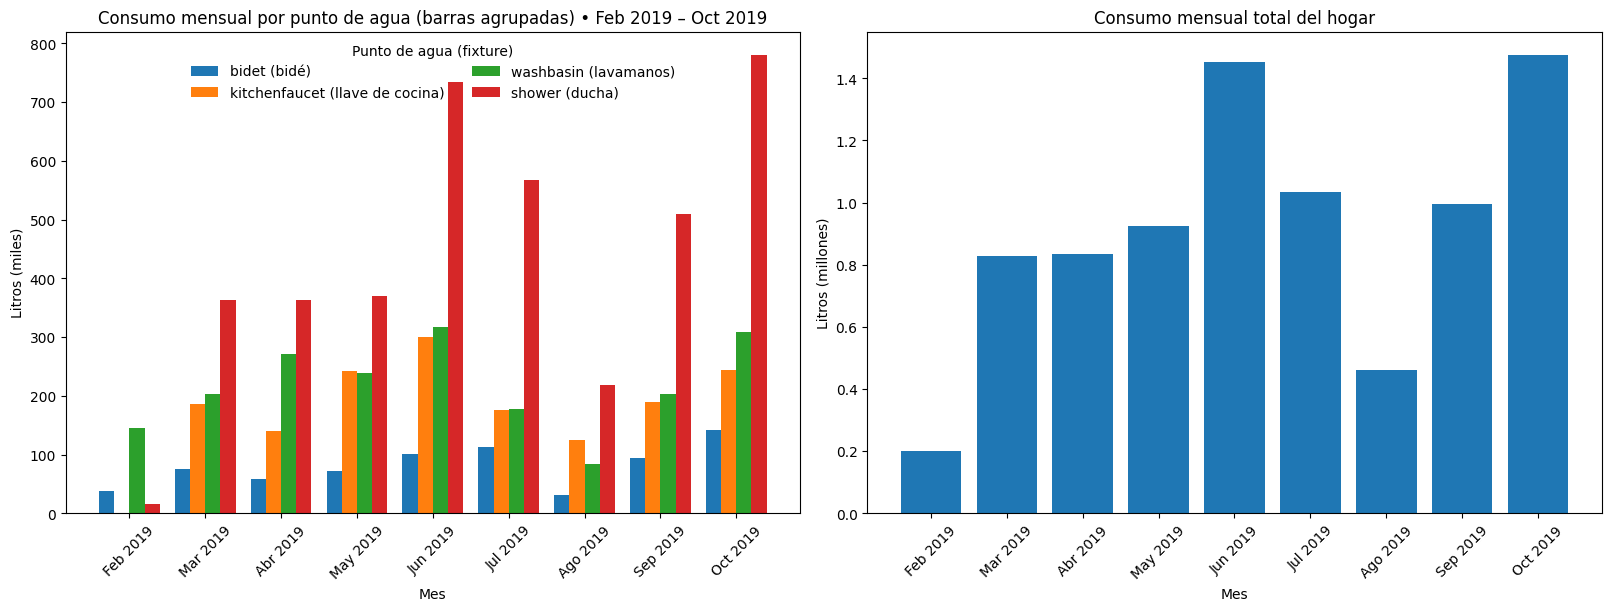

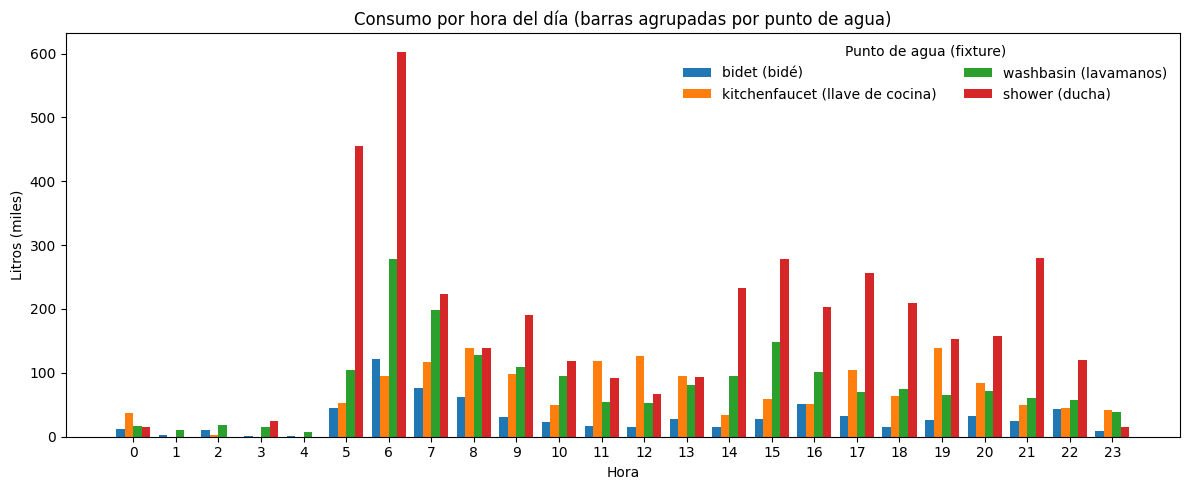

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Carga
df = pd.read_csv("../data/EL-WaterDemandTS/dataset.csv", delim_whitespace=True, header=0)
df["start_datetime"] = pd.to_datetime(df["start_datetime"], unit="s")
df["year"]  = df["start_datetime"].dt.year
df["month"] = df["start_datetime"].dt.month
df["hour"]  = df["start_datetime"].dt.hour
df["month_period"] = df["start_datetime"].dt.to_period("M")

# === Etiquetas de meses en español
MESES = {1:"Ene",2:"Feb",3:"Mar",4:"Abr",5:"May",6:"Jun",7:"Jul",8:"Ago",9:"Sep",10:"Oct",11:"Nov",12:"Dic"}
def month_label(p):
    year = int(str(p)[:4]); month = int(str(p)[5:7])
    return f"{MESES.get(month, month)} {year}"

# === Rango temporal
min_ts = df["start_datetime"].min()
max_ts = df["start_datetime"].max()
rango_str = f"{min_ts:%b %Y} – {max_ts:%b %Y}"

# === Parámetros de fixtures: orden + traducciones
fixture_order = ["bidet", "kitchenfaucet", "washbasin", "shower"]
fixture_es = {
    "bidet": "bidet (bidé)",
    "kitchenfaucet": "kitchenfaucet (llave de cocina)",
    "washbasin": "washbasin (lavamanos)",
    "shower": "shower (ducha)",
}

# === Factores de escala
factor_kL = 1_000        # miles de litros
factor_ML = 1_000_000    # millones de litros

# ==========================
# 2 + 3) Consumo mensual por fixture (kL)
#       + Consumo mensual total del hogar (ML)
# ==========================

# --- Tabla Mes × Fixture (litros) ---
pivot = (df.pivot_table(index="month_period", columns="fixture",
                        values="liters", aggfunc="sum")
           .sort_index())

# Etiquetas de meses en español
labels = [month_label(p) for p in pivot.index]

# Asegura columnas en orden requerido
for c in fixture_order:
    if c not in pivot.columns:
        pivot[c] = 0
pivot = pivot[fixture_order]

# Series escaladas
pivot_kL = pivot / factor_kL                     # para barras agrupadas (kL)
total_month_ML = pivot.sum(axis=1) / factor_ML   # total hogar (ML)

# Figura con dos subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# (Izquierda) Barras agrupadas por mes y fixture (kL)
x = np.arange(len(pivot_kL.index))
n_groups = pivot_kL.shape[1]
width = 0.8 / max(1, n_groups)

for i, col in enumerate(pivot_kL.columns):
    ax1.bar(x + i*width - 0.4 + width/2,
            pivot_kL[col].values,
            width=width, label=fixture_es[col])

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_xlabel("Mes")
ax1.set_ylabel("Litros (miles)")
ax1.set_title(f"Consumo mensual por punto de agua (barras agrupadas) • {rango_str}")
ax1.legend(title="Punto de agua (fixture)", ncol=2, frameon=False)

# (Derecha) Consumo mensual total del hogar (ML)
ax2.bar(x, total_month_ML.values, color="tab:blue")
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45)
ax2.set_xlabel("Mes")
ax2.set_ylabel("Litros (millones)")
ax2.set_title("Consumo mensual total del hogar")

plt.show()

# ==========================
# 4) Consumo por hora del día (barras agrupadas por fixture, kL)
# ==========================
pivot_hf = (df.pivot_table(index="hour", columns="fixture", values="liters", aggfunc="sum")
              .reindex(range(24), fill_value=0)
              .sort_index())
for c in fixture_order:
    if c not in pivot_hf.columns:
        pivot_hf[c] = 0
pivot_hf = pivot_hf[fixture_order]

pivot_hf_kL = pivot_hf / factor_kL

plt.figure(figsize=(12,5))
x = np.arange(24)
n_groups = pivot_hf_kL.shape[1]
width = 0.8 / max(1, n_groups)

for i, col in enumerate(pivot_hf_kL.columns):
    plt.bar(x + i*width - 0.4 + width/2,
            pivot_hf_kL[col].values,
            width=width, label=fixture_es[col])

plt.xticks(x, x)
plt.xlabel("Hora")
plt.ylabel("Litros (miles)")
plt.title("Consumo por hora del día (barras agrupadas por punto de agua)")
plt.legend(title="Punto de agua (fixture)", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


# WEUSEDTO-Data unificando

## datos modificados WEUSEDTO

In [ ]:
# ==========================
# se usará 
# kitchenfaucet (lavaplatos), washbasin (lavamanos), shower (ducha), toilet (inodoro), washingmachine (lavadora)

# dishwasher (lavavajillas) --- listo se cambiará a lavaplatos el nombre y se guardará en una nueva carpeta dataset_editado (cambiar a Lmin)
# kitchenfaucet (lavaplatos) --- se debe transformar a 3 columnas, Time Flow "End time" ya que solo tiene (Time,Flow) y se mide cada segundo
# shower (ducha) --- se debe transformar a 3 columnas, Time Flow "End time" ya que solo tiene (Time,Flow) y se mide cada segundo (esta no tiene header)
# washbasin (lavamanos) --- se debe transformar a 3 columnas, Time Flow "End time" ya que solo tiene (Time,Flow) y se mide cada segundo (esta no tiene header)
# washingmachine (lavadora) --- se debe transformar a 3 columnas, Time Flow "End time" ya que solo tiene (Time,Flow) y se mide cada segundo (esta no tiene header)
# toilet (inodoro) --- --- listo se cambiará a lavaplatos el nombre y se guardará en una nueva carpeta dataset_editado (cambiar a Lmin)

In [ ]:
import pandas as pd
import numpy as np
import os

def create_output_directory():
    output_dir = "../data/dataset_editado"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

def convert_ml_s_to_l_min(flow_ml_s):
    return flow_ml_s * 0.06  # 1 mL/s = 0.06 L/min

def detect_separator(file_path):
    with open(file_path, 'r') as f:
        first_line = f.readline()
    if ',' in first_line:
        return ','
    elif '\t' in first_line:
        return '\t'
    elif ' ' in first_line:
        return r'\s+'
    else:
        return ','  # Por defecto

def normalize_columns(df):
    """
    Normaliza nombres de columnas para que sean: Time, Flow, End_time (si existe)
    """
    new_cols = {}
    for col in df.columns:
        col_clean = col.strip().lower().replace('"', '').replace("'", "").replace(" ", "_")
        if col_clean in ['time', 'start_time', 'starttime']:
            new_cols[col] = 'Time'
        elif col_clean in ['flow', 'flow_lmin', 'flow(l/min)', 'flow_l/s', 'flow_ml/s', 'flow_ml_s']:
            new_cols[col] = 'Flow'
        elif col_clean in ['end_time', 'endtime', 'end_time_', 'end_time']:
            new_cols[col] = 'End_time'
    df = df.rename(columns=new_cols)
    return df

def process_grouping_events(df, device_name):
    print(f"Procesando {device_name} (agrupando eventos)...")

    device_time_limits = {
        'lavaplatos': 1800,
        'ducha': 3600,
        'lavamanos': 600,
        'lavadora': 7200
    }
    max_gap_seconds = device_time_limits.get(device_name, 3600)

    df = normalize_columns(df)

    # Si no tiene columnas Time y Flow, intentar asignar para archivos sin header
    if 'Time' not in df.columns or 'Flow' not in df.columns:
        if df.shape[1] >= 2:
            df.columns = ['Time', 'Flow'] + list(df.columns[2:])
        else:
            raise ValueError(f"Archivo {device_name} no tiene columnas Time y Flow")

    df['Flow'] = pd.to_numeric(df['Flow'], errors='coerce')
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df = df.sort_values('Time').reset_index(drop=True)

    flowing_data = df[df['Flow'] > 0].copy()
    if flowing_data.empty:
        print(f"No se encontraron eventos de flujo para {device_name}")
        return pd.DataFrame(columns=['Time', 'End_time', 'Duration_s', 'Flow_Lmin', 'Litros_totales'])

    flowing_data['time_diff'] = flowing_data['Time'].diff()
    flowing_data['new_event'] = (flowing_data['time_diff'] > max_gap_seconds) | flowing_data['time_diff'].isna()
    flowing_data['event_group'] = flowing_data['new_event'].cumsum()

    events = []
    for group_id in flowing_data['event_group'].unique():
        group = flowing_data[flowing_data['event_group'] == group_id]
        start_time = group['Time'].iloc[0]
        end_time = group['Time'].iloc[-1]
        duration_s = end_time - start_time
        if duration_s == 0:
            duration_s = 1

        avg_flow_ml_s = group['Flow'].mean()
        flow_l_min = convert_ml_s_to_l_min(avg_flow_ml_s)

        total_volume_ml = 0
        for i in range(len(group)):
            if i == 0:
                interval = 1
            else:
                interval = group.iloc[i]['Time'] - group.iloc[i-1]['Time']
                max_interval = min(3600, max_gap_seconds // 4)
                if interval > max_interval:
                    interval = 1
            total_volume_ml += group.iloc[i]['Flow'] * interval
        litros_totales = total_volume_ml / 1000

        min_volume = {
            'lavaplatos': 0.01,
            'ducha': 0.1,
            'lavamanos': 0.005,
            'lavadora': 1.0
        }.get(device_name, 0.001)

        if duration_s >= 1 and litros_totales >= min_volume:
            events.append({
                'Time': start_time,
                'End_time': end_time,
                'Duration_s': duration_s,
                'Flow_Lmin': flow_l_min,
                'Litros_totales': litros_totales
            })

    if not events:
        print(f"No se encontraron eventos válidos para {device_name}")
        return pd.DataFrame(columns=['Time', 'End_time', 'Duration_s', 'Flow_Lmin', 'Litros_totales'])

    result = pd.DataFrame(events)
    print(f"{device_name}: {len(result)} eventos procesados")
    return result

def process_events_with_endtime(df, device_name):
    print(f"Procesando {device_name} (ya con End_time)...")

    df = normalize_columns(df)

    # Validar columnas necesarias
    if not {'Time', 'Flow', 'End_time'}.issubset(df.columns):
        # Intentar asignar columnas si no están bien nombradas
        if df.shape[1] >= 3:
            df.columns = ['Time', 'Flow', 'End_time'] + list(df.columns[3:])
        else:
            raise ValueError(f"Faltan columnas necesarias en {device_name}")

    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['End_time'] = pd.to_numeric(df['End_time'], errors='coerce')
    df['Flow'] = pd.to_numeric(df['Flow'], errors='coerce')

    df['Flow_Lmin'] = convert_ml_s_to_l_min(df['Flow'])

    df['Duration_s'] = df['End_time'] - df['Time']
    df.loc[df['Duration_s'] <= 0, 'Duration_s'] = 1

    df['Litros_totales'] = df['Flow_Lmin'] * df['Duration_s'] / 60

    result = df[['Time', 'End_time', 'Duration_s', 'Flow_Lmin', 'Litros_totales']].copy()

    print(f"{device_name}: {len(result)} eventos procesados")
    return result

def main():
    files_config = {
        'feed_Kitchenfaucet.MYD.csv': {
            'spanish_name': 'lavaplatos',
            'has_header': True,
            'process_func': process_grouping_events
        },
        'feed_Shower.MYD.csv': {
            'spanish_name': 'ducha',
            'has_header': False,
            'process_func': process_grouping_events
        },
        'feed_Washbasin.MYD.csv': {
            'spanish_name': 'lavamanos',
            'has_header': False,
            'process_func': process_grouping_events
        },
        'feed_Washingmachine.MYD.csv': {
            'spanish_name': 'lavadora',
            'has_header': False,
            'process_func': process_grouping_events
        },
        'feed.Toilet.csv': {
            'spanish_name': 'inodoro',
            'has_header': True,
            'process_func': process_events_with_endtime
        },
        'feed_Dishwasher30.MYD.csv': {
            'spanish_name': 'lavavajillas',
            'has_header': True,
            'process_func': process_events_with_endtime
        }
    }

    input_dir = "../data/WEUSEDTO-Data"
    output_dir = create_output_directory()

    print("=== PROCESADOR DE DATASETS DE CONSUMO DE AGUA ===\n")

    for filename, config in files_config.items():
        try:
            file_path = os.path.join(input_dir, filename)
            print(f"Cargando: {filename}")

            sep = detect_separator(file_path)

            if config['has_header']:
                df = pd.read_csv(file_path, sep=sep)
            else:
                df = pd.read_csv(file_path, sep=sep, header=None)
                # Asignar nombres para archivos sin header
                if df.shape[1] == 2:
                    df.columns = ['Time', 'Flow']
                elif df.shape[1] == 3:
                    df.columns = ['Time', 'Flow', 'End_time']
                else:
                    df.columns = [f'Col_{i}' for i in range(df.shape[1])]

            processed_df = config['process_func'](df, config['spanish_name'])

            output_filename = f"{config['spanish_name']}.csv"
            output_path = os.path.join(output_dir, output_filename)
            processed_df.to_csv(output_path, index=False)
            print(f"Guardado: {output_path}")
            print(f"Eventos finales: {len(processed_df)}")

            if len(processed_df) > 0:
                print(f"  - Duración promedio: {processed_df['Duration_s'].mean():.2f} segundos")
                print(f"  - Flujo promedio: {processed_df['Flow_Lmin'].mean():.2f} L/min")
                print(f"  - Litros promedio por evento: {processed_df['Litros_totales'].mean():.2f} L")

            print("-" * 50)

        except FileNotFoundError:
            print(f"Error: No se encontró el archivo {filename} en {input_dir}")
        except Exception as e:
            print(f"Error procesando {filename}: {str(e)}")
            import traceback
            traceback.print_exc()

        print()

    print("=== PROCESAMIENTO COMPLETADO ===")
    print(f"Todos los archivos procesados se guardaron en: {output_dir}")
    print("\nColumnas finales en todos los datasets:")
    print("- Time: inicio del evento")
    print("- End_time: fin del evento")
    print("- Duration_s: duración en segundos")
    print("- Flow_Lmin: flujo promedio en litros/min")
    print("- Litros_totales: volumen total en litros")

if __name__ == "__main__":
    main()

=== PROCESADOR DE DATASETS DE CONSUMO DE AGUA ===

Cargando: feed_Kitchenfaucet.MYD.csv
Procesando lavaplatos (agrupando eventos)...
lavaplatos: 1368 eventos procesados
Guardado: ../data/dataset_editado\lavaplatos.csv
Eventos finales: 1368
  - Duración promedio: 856.57 segundos
  - Flujo promedio: 2.23 L/min
  - Litros promedio por evento: 7.67 L
--------------------------------------------------

Cargando: feed_Shower.MYD.csv
Procesando ducha (agrupando eventos)...
ducha: 338 eventos procesados
Guardado: ../data/dataset_editado\ducha.csv
Eventos finales: 338
  - Duración promedio: 1060.00 segundos
  - Flujo promedio: 4.18 L/min
  - Litros promedio por evento: 23.71 L
--------------------------------------------------

Cargando: feed_Washbasin.MYD.csv
Procesando lavamanos (agrupando eventos)...
lavamanos: 2381 eventos procesados
Guardado: ../data/dataset_editado\lavamanos.csv
Eventos finales: 2381
  - Duración promedio: 210.82 segundos
  - Flujo promedio: 1.82 L/min
  - Litros promedio

## Unificado

In [1]:
import pandas as pd
import os

def unificar_datasets_editados():
    input_dir = "../data/dataset_editado"
    # Excluir lavadora y lavavajillas
    dispositivos = ['lavaplatos', 'ducha', 'lavamanos', 'inodoro']

    dfs = []
    for disp in dispositivos:
        file_path = os.path.join(input_dir, f"{disp}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Dispositivo'] = disp
            dfs.append(df)
        else:
            print(f"Advertencia: No se encontró el archivo {file_path}")

    if not dfs:
        print("No se encontraron archivos para unificar.")
        return None

    df_unificado = pd.concat(dfs, ignore_index=True)

    # Ordenar solo por Time ascendente
    df_unificado = df_unificado.sort_values('Time').reset_index(drop=True)

    # Guardar archivo unificado
    output_path = os.path.join(input_dir, "dataset_unificado.csv")
    df_unificado.to_csv(output_path, index=False)
    print(f"Archivo unificado guardado en: {output_path}")

    return df_unificado

if __name__ == "__main__":
    df_final = unificar_datasets_editados()
    if df_final is not None:
        print(f"Total filas unificadas: {len(df_final)}")
        print("Primeras filas del dataset unificado:")
        print(df_final.head())

Archivo unificado guardado en: ../data/dataset_editado\dataset_unificado.csv
Total filas unificadas: 5275
Primeras filas del dataset unificado:
         Time    End_time  Duration_s  Flow_Lmin  Litros_totales Dispositivo
0  1550048311  1550048312           1   5.310000           0.177   lavamanos
1  1550056694  1550056700           6   3.576000           0.365       ducha
2  1550336126  1550336134           8   3.040000           0.188   lavamanos
3  1550338324  1550338586         262   2.460000           0.369   lavamanos
4  1550339333  1550339347          14   2.417143           0.611   lavamanos


## graficos generales

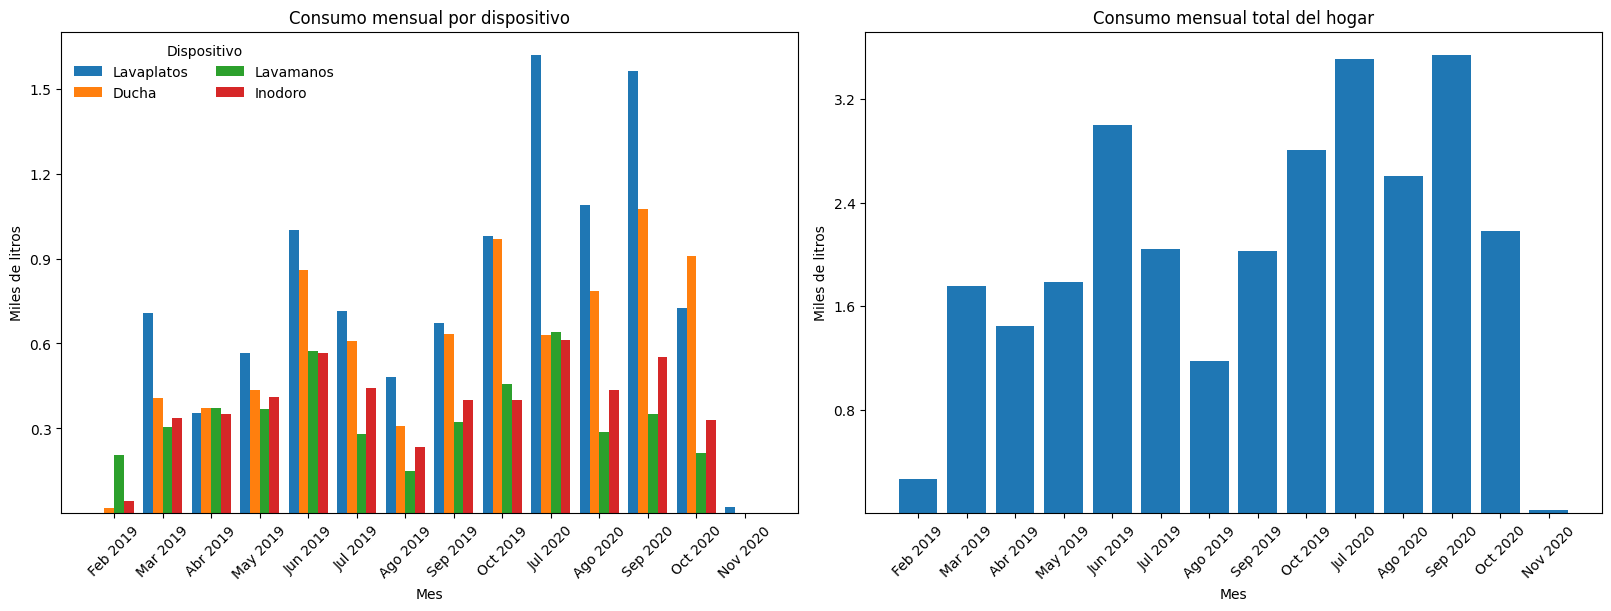

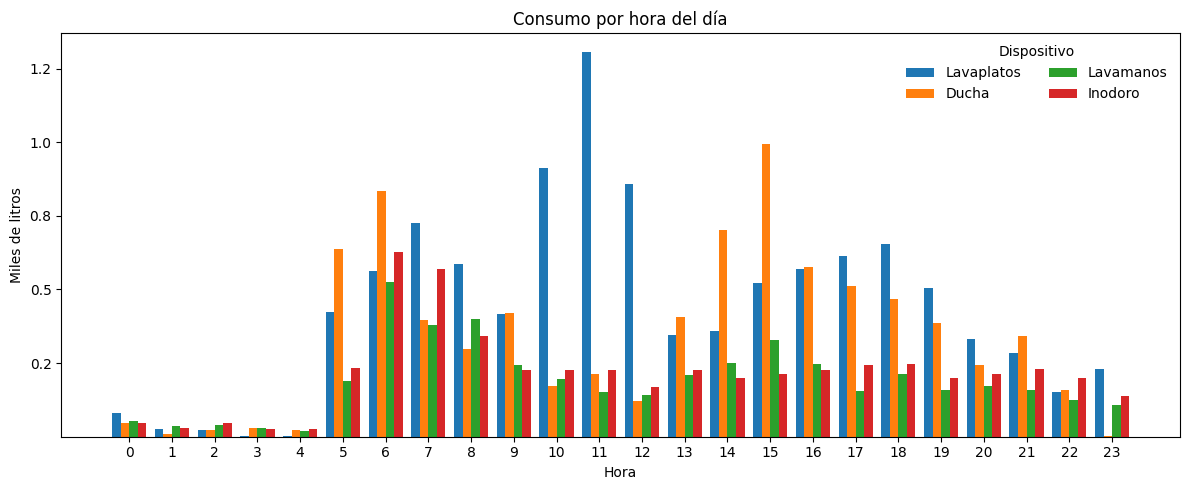

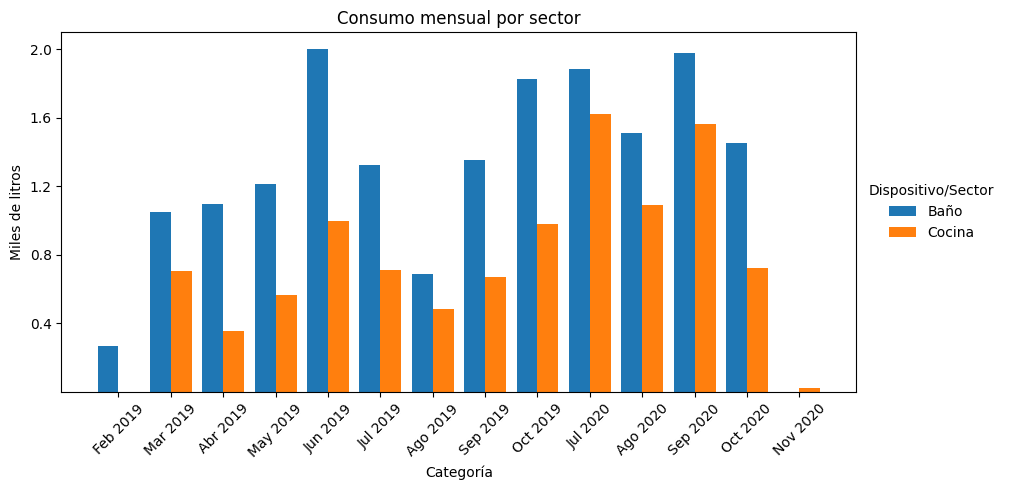

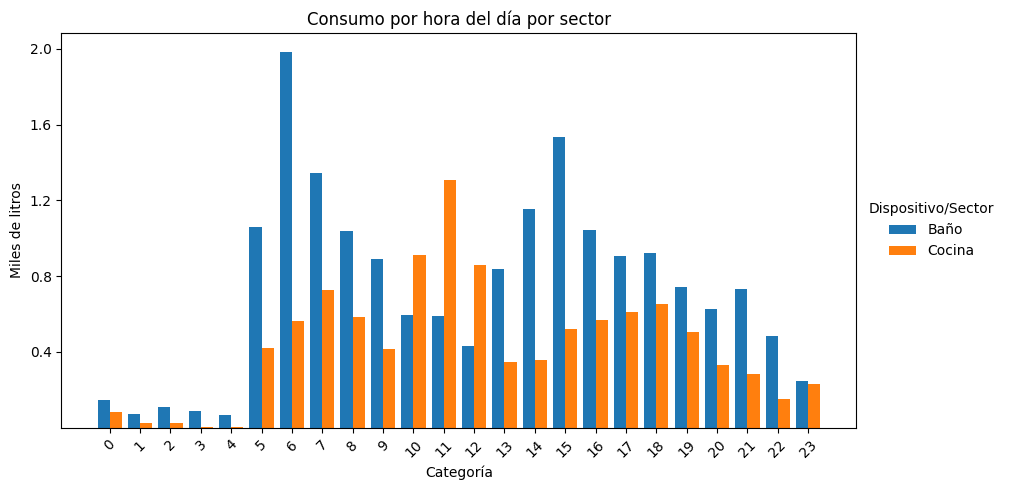

In [5]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# =========================
# Utilidades de formato
# =========================
def month_label(p):
    MESES = {1:"Ene",2:"Feb",3:"Mar",4:"Abr",5:"May",6:"Jun",7:"Jul",8:"Ago",9:"Sep",10:"Oct",11:"Nov",12:"Dic"}
    year = int(str(p)[:4])
    month = int(str(p)[5:7])
    return f"{MESES.get(month, month)} {year}"

def elegir_unidad(max_val_liters: float):
    """
    Devuelve (factor, etiqueta legible) según el máximo valor en litros.
    """
    if max_val_liters >= 1_000_000_000:   # >= mil millones
        return 1_000_000_000, "Mil millones de litros"
    if max_val_liters >= 1_000_000:       # >= un millón
        return 1_000_000, "Millones de litros"
    if max_val_liters >= 1_000:           # >= mil
        return 1_000, "Miles de litros"
    return 1, "Litros"

def fmt_num_1dec():
    return FuncFormatter(lambda x, pos: f"{x:,.1f}")

def aplicar_formato_eje_y(ax, n_ticks=6):
    ax.yaxis.set_major_locator(MaxNLocator(nbins=n_ticks, prune="both"))
    ax.yaxis.set_major_formatter(fmt_num_1dec())
    ax.set_ylim(bottom=0)

def plot_grouped_bars(df_vals, x_labels, title, y_label, legend_side="right"):
    """
    df_vals: DataFrame ya ESCALADO a la unidad final (no en litros).
    """
    x = np.arange(len(df_vals.index))
    n = df_vals.shape[1]
    width = 0.8 / max(1, n)

    fig, ax = plt.subplots(figsize=(12, 5))
    for i, col in enumerate(df_vals.columns):
        ax.bar(x + i*width - 0.4 + width/2, df_vals[col].values, width=width, label=col)

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_xlabel("Categoría")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    aplicar_formato_eje_y(ax)

    if legend_side == "right":
        ax.legend(title="Dispositivo/Sector", loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
    elif legend_side == "left":
        ax.legend(title="Dispositivo/Sector", loc="center right", bbox_to_anchor=(-0.02, 0.5), frameon=False)
        plt.tight_layout(rect=[0.12, 0, 1, 1])
    else:
        ax.legend(title="Dispositivo/Sector", frameon=False)
        plt.tight_layout()

    plt.show()

# =========================
# Carga de datos
# =========================
input_path = "../data/dataset_editado/dataset_unificado.csv"
if not os.path.exists(input_path):
    raise FileNotFoundError(f"No se encontró el archivo unificado en {input_path}")

df = pd.read_csv(input_path)

# --- Adaptar columnas y tipos ---
df['start_datetime'] = pd.to_datetime(df['Time'], unit='s')
df['year'] = df['start_datetime'].dt.year
df['month'] = df['start_datetime'].dt.month
df['hour'] = df['start_datetime'].dt.hour
df['month_period'] = df['start_datetime'].dt.to_period('M')

# Dispositivos en español
dispositivos = ['lavaplatos', 'ducha', 'lavamanos', 'inodoro']
df = df[df['Dispositivo'].isin(dispositivos)].copy()
df['litros'] = df['Litros_totales']

dispositivo_order = ['lavaplatos', 'ducha', 'lavamanos', 'inodoro']
dispositivo_nombres = {
    'lavaplatos': 'Lavaplatos',
    'ducha': 'Ducha',
    'lavamanos': 'Lavamanos',
    'inodoro': 'Inodoro'
}

# =========================
# 1) Consumo mensual por dispositivo + total mensual
# =========================
pivot = (df.pivot_table(index="month_period", columns="Dispositivo",
                        values="litros", aggfunc="sum")
           .sort_index().fillna(0.0))

for d in dispositivo_order:
    if d not in pivot.columns:
        pivot[d] = 0.0
pivot = pivot[dispositivo_order]
pivot.columns = [dispositivo_nombres.get(c, c) for c in pivot.columns]

labels = [month_label(p) for p in pivot.index]

# Auto-escala
factor_disp, unidad_disp = elegir_unidad(float(pivot.values.max()))
pivot_scaled = np.round(pivot / factor_disp, 3)

total_mes = pivot.sum(axis=1)
factor_total, unidad_total = elegir_unidad(float(total_mes.max()))
total_mes_scaled = np.round(total_mes / factor_total, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

x = np.arange(len(pivot_scaled.index))
n_groups = pivot_scaled.shape[1]
width = 0.8 / max(1, n_groups)

for i, col in enumerate(pivot_scaled.columns):
    ax1.bar(x + i*width - 0.4 + width/2, pivot_scaled[col].values, width=width, label=col)

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_xlabel("Mes")
ax1.set_ylabel(unidad_disp)
ax1.set_title("Consumo mensual por dispositivo")
aplicar_formato_eje_y(ax1)
ax1.legend(title="Dispositivo", ncol=2, frameon=False)

ax2.bar(x, total_mes_scaled.values)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45)
ax2.set_xlabel("Mes")
ax2.set_ylabel(unidad_total)
ax2.set_title("Consumo mensual total del hogar")
aplicar_formato_eje_y(ax2)

plt.show()

# =========================
# 2) Consumo por hora del día
# =========================
pivot_hf = (df.pivot_table(index="hour", columns="Dispositivo",
                           values="litros", aggfunc="sum")
              .reindex(range(24), fill_value=0.0).sort_index())

for d in dispositivo_order:
    if d not in pivot_hf.columns:
        pivot_hf[d] = 0.0
pivot_hf = pivot_hf[dispositivo_order]
pivot_hf.columns = [dispositivo_nombres.get(c, c) for c in pivot_hf.columns]

factor_hora, unidad_hora = elegir_unidad(float(pivot_hf.values.max()))
pivot_hf_scaled = np.round(pivot_hf / factor_hora, 3)

plt.figure(figsize=(12,5))
x = np.arange(24)
n_groups = pivot_hf_scaled.shape[1]
width = 0.8 / max(1, n_groups)

for i, col in enumerate(pivot_hf_scaled.columns):
    plt.bar(x + i*width - 0.4 + width/2, pivot_hf_scaled[col].values,
            width=width, label=col)

plt.xticks(x, x)
plt.xlabel("Hora")
plt.ylabel(unidad_hora)
plt.title("Consumo por hora del día")
aplicar_formato_eje_y(plt.gca())
plt.legend(title="Dispositivo", ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# =========================
# 3) Gráficos por sector
# =========================
sector_map = {
    "Baño":   ["ducha", "lavamanos", "inodoro"],
    "Cocina": ["lavaplatos"],
}

present = set(df["Dispositivo"].unique())
otros = sorted({d for d in present if d not in sum(sector_map.values(), [])})
if otros:
    sector_map["Otros"] = otros

for s, dispositivos_sector in list(sector_map.items()):
    sector_map[s] = [d for d in dispositivos_sector if d in present]
sector_map = {s: ds for s, ds in sector_map.items() if ds}

piv_disp_month = (df.pivot_table(index="month_period", columns="Dispositivo",
                                 values="litros", aggfunc="sum")
                  .sort_index().fillna(0.0))
piv_sector_month = pd.DataFrame(index=piv_disp_month.index)
for sector, dispositivos_sector in sector_map.items():
    piv_sector_month[sector] = piv_disp_month[dispositivos_sector].sum(axis=1) if dispositivos_sector else 0.0

factor_sec_m, unidad_sec_m = elegir_unidad(float(piv_sector_month.values.max()))
labels_months = [month_label(p) for p in piv_sector_month.index]
plot_grouped_bars(
    df_vals=np.round(piv_sector_month / factor_sec_m, 3),
    x_labels=labels_months,
    title="Consumo mensual por sector",
    y_label=unidad_sec_m,
    legend_side="right"
)

piv_disp_hour = (df.pivot_table(index="hour", columns="Dispositivo",
                                values="litros", aggfunc="sum")
                 .reindex(range(24), fill_value=0.0).sort_index())
piv_sector_hour = pd.DataFrame(index=piv_disp_hour.index)
for sector, dispositivos_sector in sector_map.items():
    piv_sector_hour[sector] = piv_disp_hour[dispositivos_sector].sum(axis=1) if dispositivos_sector else 0.0

factor_sec_h, unidad_sec_h = elegir_unidad(float(piv_sector_hour.values.max()))
plot_grouped_bars(
    df_vals=np.round(piv_sector_hour / factor_sec_h, 3),
    x_labels=list(piv_sector_hour.index),
    title="Consumo por hora del día por sector",
    y_label=unidad_sec_h,
    legend_side="right"
)


## visualización en segundos y minutos

C:\Users\alvar\AppData\Local\Temp\ipykernel_19448\4181543910.py:55: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  idx = pd.date_range(start=start_ts, end=end_ts, freq=freq, inclusive="left")
C:\Users\alvar\AppData\Local\Temp\ipykernel_19448\4181543910.py:77: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  rng = pd.date_range(s.floor("S"), (e - pd.Timedelta(seconds=1)).floor("S"), freq="S")
C:\Users\alvar\AppData\Local\Temp\ipykernel_19448\4181543910.py:55: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  idx = pd.date_range(start=start_ts, end=end_ts, freq=freq, inclusive="left")
C:\Users\alvar\AppData\Local\Temp\ipykernel_19448\4181543910.py:77: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  rng = pd.date_range(s.floor("S"), (e - pd.Timedelta(seconds=1)).floor("S"), freq="S")
C:

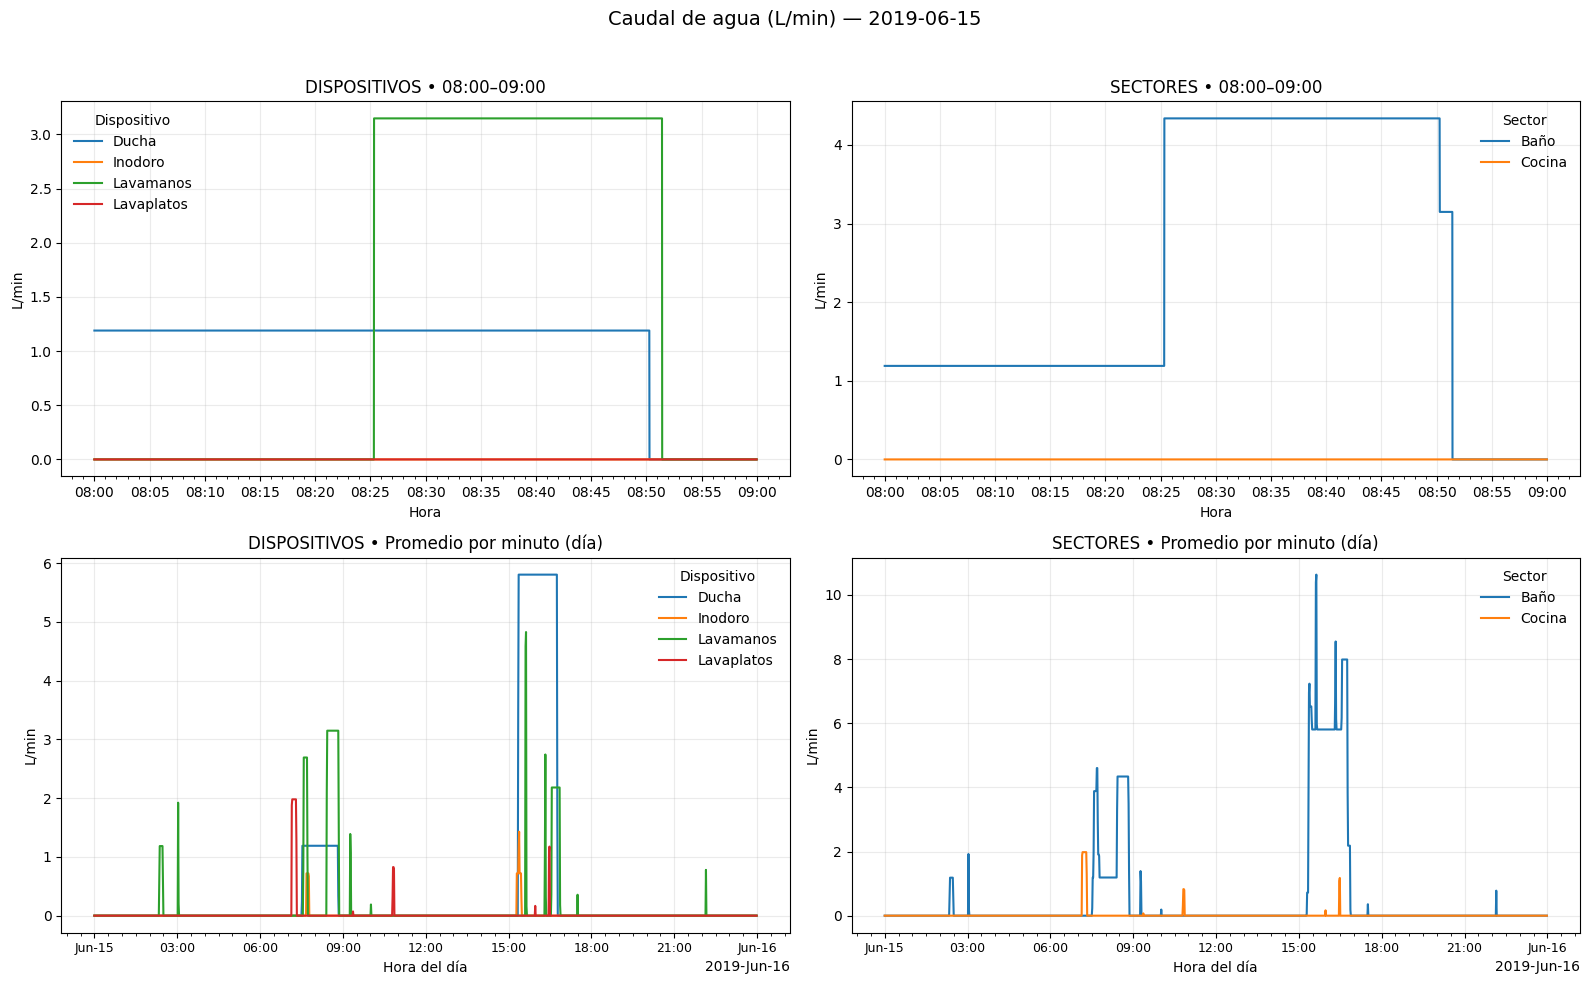

In [10]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.dates as mdates

# =========================
# Parámetros de visualización
# =========================
DAY_STR = "2019-06-15"   # <-- día a visualizar (YYYY-MM-DD)
HOUR_OF_DAY = 8          # <-- hora para el gráfico por segundo (8 => 08:00–09:00)

input_path = "../data/dataset_editado/dataset_unificado.csv"
if not os.path.exists(input_path):
    raise FileNotFoundError(f"No se encontró {input_path}")

# =========================
# Carga y preparación
# =========================
df = pd.read_csv(input_path)

# Parseo a datetime (asumiendo epoch segundos)
df["start_dt"] = pd.to_datetime(df["Time"], unit="s", utc=True).dt.tz_localize(None)
df["end_dt"]   = pd.to_datetime(df["End_time"], unit="s", utc=True).dt.tz_localize(None)

# Filtramos eventos con tiempos válidos y flujo válido
df = df.dropna(subset=["start_dt", "end_dt", "Flow_Lmin"])
df = df[df["end_dt"] > df["start_dt"]].copy()

# Mapeo dispositivo → sector
map_bano   = {"ducha","lavamanos","inodoro"}
map_cocina = {"lavaplatos"}

def dispositivo_a_sector(d):
    d = str(d).strip().lower()
    if d in map_bano:   return "Baño"
    if d in map_cocina: return "Cocina"
    return "Otros"

df["Sector"] = df["Dispositivo"].apply(dispositivo_a_sector)

# Considerar solo Baño y Cocina
df = df[df["Sector"].isin(["Baño","Cocina"])].copy()

# =========================
# Funciones para reconstruir la serie de flujo (L/min)
# =========================
def build_flow_series(df_events, start_ts, end_ts, freq="S"):
    """
    Construye una serie temporal con columnas por DISPOSITIVO (L/min),
    con muestreo 'S' (segundo) o 'T' (minuto). Suma superposiciones.
    """
    idx = pd.date_range(start=start_ts, end=end_ts, freq=freq, inclusive="left")
    dispositivos = sorted(df_events["Dispositivo"].str.lower().unique())
    if len(dispositivos) == 0:
        return pd.DataFrame(index=idx)

    flow_df = pd.DataFrame(0.0, index=idx, columns=dispositivos)

    # Filtrado rápido por rango
    mask = (df_events["end_dt"] > start_ts) & (df_events["start_dt"] < end_ts)
    if not mask.any():
        return flow_df

    for _, r in df_events.loc[mask].iterrows():
        d = str(r["Dispositivo"]).strip().lower()
        flow_lmin = float(r["Flow_Lmin"])
        s = max(r["start_dt"], start_ts)
        e = min(r["end_dt"],   end_ts)
        if s >= e:
            continue

        if freq == "S":
            # Rango por segundo: [s, e) en pasos de 1 s
            rng = pd.date_range(s.floor("S"), (e - pd.Timedelta(seconds=1)).floor("S"), freq="S")
            if len(rng) == 0:
                continue
            flow_df.loc[rng, d] += flow_lmin  # L/min instantáneo
        elif freq == "T":
            # Rango por minuto (aprox; mejor construir en S y luego resamplear a T)
            rng = pd.date_range(s.floor("T"), (e - pd.Timedelta(minutes=1)).floor("T"), freq="T")
            if len(rng) == 0:
                rng = pd.DatetimeIndex([s.floor("T")])
            flow_df.loc[rng, d] += flow_lmin
        else:
            raise ValueError("freq debe ser 'S' o 'T'")

    return flow_df

def to_sector_flow(flow_df, sector_map):
    """
    Agrupa columnas de dispositivos en sectores (suma).
    """
    out = pd.DataFrame(index=flow_df.index)
    lower_cols = [c.lower() for c in flow_df.columns]
    col_map = dict(zip(lower_cols, flow_df.columns))  # map back to real case
    for sector, devs in sector_map.items():
        devs_lower = [d.lower() for d in devs if d.lower() in col_map]
        if devs_lower:
            out[sector] = flow_df[[col_map[d] for d in devs_lower]].sum(axis=1)
        else:
            out[sector] = 0.0
    return out

# =========================
# Ventanas de tiempo
# =========================
day_start = pd.to_datetime(DAY_STR)
day_end   = day_start + pd.Timedelta(days=1)

hour_start = day_start + pd.Timedelta(hours=int(HOUR_OF_DAY))
hour_end   = hour_start + pd.Timedelta(hours=1)

# =========================
# Series necesarias
# =========================
# 1) Por segundo (1 hora) → dispositivos y sectores
flow_sec_dev = build_flow_series(df, hour_start, hour_end, freq="S")
sector_map = {"Baño": ["ducha","lavamanos","inodoro"], "Cocina": ["lavaplatos"]}
flow_sec_sector = to_sector_flow(flow_sec_dev, sector_map)

# Ejes relativos para 1 hora (en MINUTOS)
# (antes segundos: ahora convertimos segundos→minutos)
x_min_dev_hour = ((flow_sec_dev.index - hour_start).total_seconds() / 60.0).astype(float) if not flow_sec_dev.empty else np.array([])
x_min_sec_hour = ((flow_sec_sector.index - hour_start).total_seconds() / 60.0).astype(float) if not flow_sec_sector.empty else np.array([])

# 2) Por minuto (día completo) → dispositivos y sectores
flow_day_sec_dev = build_flow_series(df, day_start, day_end, freq="S")
# Promedio L/min por minuto (suaviza)
flow_day_min_dev = flow_day_sec_dev.resample("T").mean() if not flow_day_sec_dev.empty else pd.DataFrame()
flow_day_min_sector = to_sector_flow(flow_day_min_dev, sector_map) if not flow_day_min_dev.empty else pd.DataFrame()

# Ejes relativos para el día (en HORAS)
x_hours_dev_day = (((flow_day_min_dev.index - day_start).total_seconds() / 60.0) / 60.0).astype(float) if not flow_day_min_dev.empty else np.array([])
x_hours_sec_day = (((flow_day_min_sector.index - day_start).total_seconds() / 60.0) / 60.0).astype(float) if not flow_day_min_sector.empty else np.array([])

# =========================
# Figure con SUBFIGURAS (2x2) — con ejes X ajustados
# =========================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
(ax11, ax12), (ax21, ax22) = axes

# --- (1,1) Dispositivos: 1 hora, 1 s (X = timestamps HH:MM)
if flow_sec_dev.empty:
    ax11.text(0.5, 0.5, "Sin datos en la hora seleccionada", ha="center", va="center")
else:
    for col in flow_sec_dev.columns:
        ax11.plot(flow_sec_dev.index, flow_sec_dev[col].values, label=col.capitalize())
    ax11.set_title(f"DISPOSITIVOS • {hour_start:%H:00}–{hour_end:%H:00}")
    ax11.set_xlabel("Hora")
    ax11.set_ylabel("L/min")
    ax11.legend(title="Dispositivo", frameon=False)
    ax11.grid(alpha=0.25)
    ax11.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0,60,5)))  # cada 5 min
    ax11.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))              # cada 1 min
    ax11.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# --- (1,2) Sectores: 1 hora, 1 s (X = timestamps HH:MM)
if flow_sec_sector.empty:
    ax12.text(0.5, 0.5, "Sin datos en la hora seleccionada", ha="center", va="center")
else:
    for col in flow_sec_sector.columns:
        ax12.plot(flow_sec_sector.index, flow_sec_sector[col].values, label=col)
    ax12.set_title(f"SECTORES • {hour_start:%H:00}–{hour_end:%H:00}")
    ax12.set_xlabel("Hora")
    ax12.set_ylabel("L/min")
    ax12.legend(title="Sector", frameon=False)
    ax12.grid(alpha=0.25)
    ax12.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    ax12.xaxis.set_minor_locator(mdates.MinuteLocator(interval=1))
    ax12.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# --- (2,1) Dispositivos: día completo, 1 min (X = timestamps)
if flow_day_min_dev.empty:
    ax21.text(0.5, 0.5, "Sin datos en el día", ha="center", va="center")
else:
    for col in flow_day_min_dev.columns:
        ax21.plot(flow_day_min_dev.index, flow_day_min_dev[col].values, label=col.capitalize())
    ax21.set_title("DISPOSITIVOS • Promedio por minuto (día)")
    ax21.set_xlabel("Hora del día")
    ax21.set_ylabel("L/min")
    ax21.legend(title="Dispositivo", frameon=False)
    ax21.grid(alpha=0.25)

    # ↓↓↓ menos etiquetas + formato compacto
    locator_day = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter_day = mdates.ConciseDateFormatter(locator_day)
    ax21.xaxis.set_major_locator(locator_day)
    ax21.xaxis.set_major_formatter(formatter_day)

    # (opcional) marcas menores cada 30 min sin etiquetas
    ax21.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
    ax21.tick_params(axis='x', which='minor', length=2, labelbottom=False)

    # (opcional) tamaño de fuente
    ax21.tick_params(axis='x', labelsize=9)

# --- (2,2) Sectores: día completo, 1 min (X = timestamps)
if flow_day_min_sector.empty:
    ax22.text(0.5, 0.5, "Sin datos en el día", ha="center", va="center")
else:
    for col in flow_day_min_sector.columns:
        ax22.plot(flow_day_min_sector.index, flow_day_min_sector[col].values, label=col)
    ax22.set_title("SECTORES • Promedio por minuto (día)")
    ax22.set_xlabel("Hora del día")
    ax22.set_ylabel("L/min")
    ax22.legend(title="Sector", frameon=False)
    ax22.grid(alpha=0.25)

    # ↓↓↓ igual que arriba
    locator_day = mdates.AutoDateLocator(minticks=6, maxticks=10)
    formatter_day = mdates.ConciseDateFormatter(locator_day)
    ax22.xaxis.set_major_locator(locator_day)
    ax22.xaxis.set_major_formatter(formatter_day)

    ax22.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
    ax22.tick_params(axis='x', which='minor', length=2, labelbottom=False)
    ax22.tick_params(axis='x', labelsize=9)



fig.suptitle(f"Caudal de agua (L/min) — {day_start:%Y-%m-%d}", fontsize=14, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Entrenamiento

Tamaños → Train: 3691 | Val: 792 | Test: 792
Distribución Train:
 Sector
Baño      0.74
Cocina    0.26
Name: proportion, dtype: float64
Distribución Val:
 Sector
Baño      0.741
Cocina    0.259
Name: proportion, dtype: float64
Distribución Test:
 Sector
Baño      0.741
Cocina    0.259
Name: proportion, dtype: float64

=== LogisticRegression (validación) ===

——— Val_LogisticRegression: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.863  0.700 0.773    587.0
Cocina     0.443  0.683 0.537    205.0

——— Val_LogisticRegression: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.696             0.653          0.692      0.655         0.712


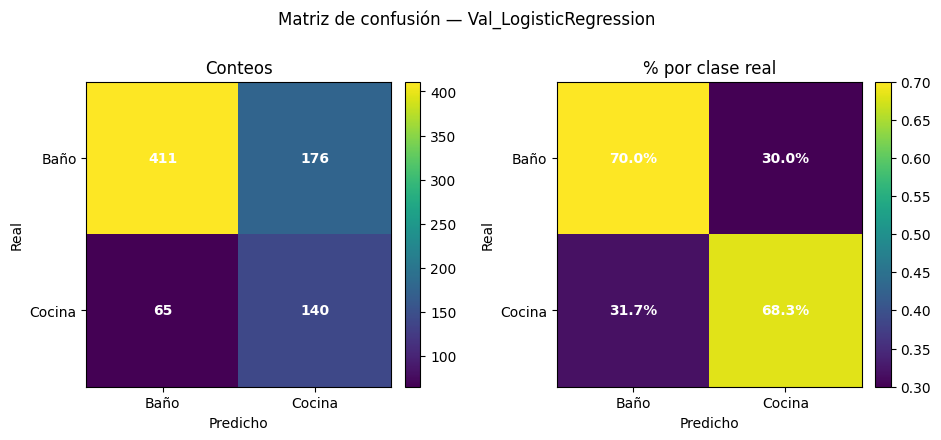


=== RandomForest (validación) ===

——— Val_RandomForest: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.857  0.901 0.879    587.0
Cocina     0.669  0.571 0.616    205.0

——— Val_RandomForest: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.816             0.763          0.736      0.747         0.811


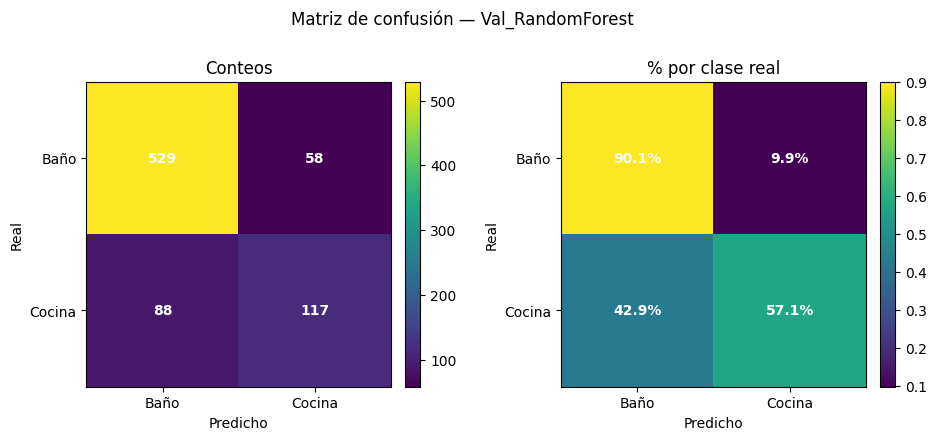


——— Ranking validación (F1 macro) ———
            Modelo  F1_macro
      RandomForest     0.747
LogisticRegression     0.655

>>> Mejor en validación: RandomForest (F1 macro=0.747)

=== Evaluación en TEST: RandomForest ===

——— Test_RandomForest: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.859  0.910 0.883    587.0
Cocina     0.688  0.571 0.624    205.0

——— Test_RandomForest: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.822             0.773          0.740      0.754         0.816


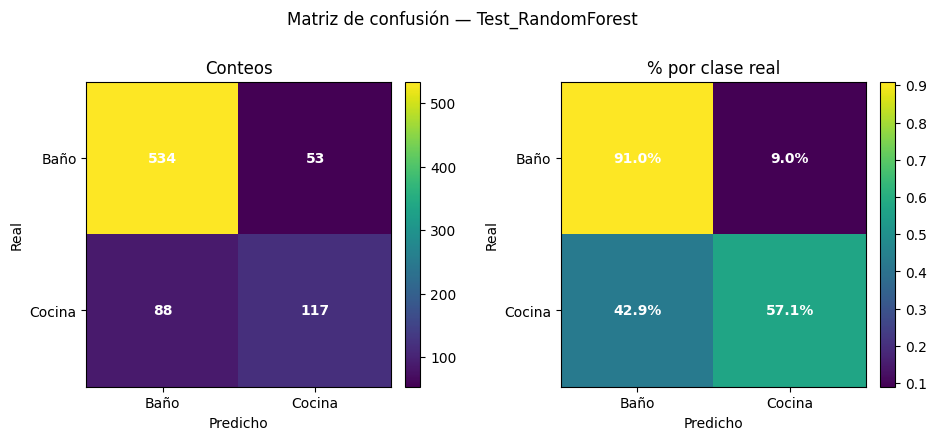


Modelo guardado en: ..\data\dataset_editado\modelos\sector_eventos_RandomForest.joblib

——— Predicción de evento ———
Predicción: Cocina
Probabilidades por clase:
  Baño       : 0.188
  Cocina     : 0.812


In [10]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, accuracy_score, precision_score, recall_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# =========================
# Configuración
# =========================
DATA_DIR = Path(r"../data/dataset_editado")
INPUT_FILE = DATA_DIR / "dataset_unificado.csv"
OUT_DIR = DATA_DIR / "modelos"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 123
TEST_SIZE = 0.15   # 15%
VAL_SIZE  = 0.15   # 15% (se hará después de separar test)
SHOW_PLOTS = True  # pon True si quieres verlos en pantalla además de guardarlos
# =========================
# Utilidades de dominio
# =========================
def dispositivo_a_sector(d):
    d = str(d).strip().lower()
    map_bano   = {"ducha","lavamanos","inodoro"}
    map_cocina = {"lavaplatos"}
    map_lavado = {"lavadora","lavavajillas"}  # por ahora NO los usamos
    if d in map_bano:   return "Baño"
    if d in map_cocina: return "Cocina"
    if d in map_lavado: return "Lavado"
    return "Otros"

def to_datetime_s(epoch_or_str):
    # Si viene en epoch (s), lo parsea. Si no, intenta parseo general.
    try:
        return pd.to_datetime(epoch_or_str, unit="s", utc=True).tz_localize(None)
    except Exception:
        return pd.to_datetime(epoch_or_str, errors="coerce")

def construir_features_df(df):
    """Crea features desde columnas: Time, Duration_s, Flow_Lmin, Litros_totales."""
    df = df.copy()
    df["_start_dt"] = df["Time"].apply(to_datetime_s)

    # Derivadas temporales
    df["hora"]       = df["_start_dt"].dt.hour
    df["minuto"]     = df["_start_dt"].dt.minute
    df["segundo"]    = df["_start_dt"].dt.second
    df["dia_semana"] = df["_start_dt"].dt.dayofweek  # 0=lunes

    # Caudales y densidades
    df["Flow_Ls_mean"] = df["Flow_Lmin"] / 60.0
    df["Flow_Ls_max"]  = df["Flow_Ls_mean"]  # placeholder si no tienes pico
    df["L_por_s"]      = df["Litros_totales"] / df["Duration_s"].clip(lower=1)

    # Transformaciones log (estabilizan colas)
    df["log_Litros"] = np.log1p(df["Litros_totales"])
    df["log_Dur"]    = np.log1p(df["Duration_s"])
    df["log_FlowLm"] = np.log1p(df["Flow_Lmin"])

    # Lista final de features numéricas
    num_features = [
        "Litros_totales", "Duration_s", "Flow_Lmin",
        "Flow_Ls_mean", "Flow_Ls_max", "L_por_s",
        "hora", "minuto", "segundo", "dia_semana",
        "log_Litros", "log_Dur", "log_FlowLm"
    ]
    return df, num_features

# =========================
# Utilidades de visualización de métricas
# =========================
def ensure_dir(p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

def plot_confusions_compact(cm_counts, cm_percent, classes, title, save_path=None):
    """
    Dibuja DOS matrices de confusión (conteos y % por clase real) en una sola figura (2 columnas).
    - cm_counts: confusion_matrix(..., normalize=None)
    - cm_percent: confusion_matrix(..., normalize="true")
    """
    import numpy as np
    fig, axes = plt.subplots(1, 2, figsize=(9.6, 4.2))  # UNA sola figura con 2 subplots

    # --- Panel 1: Conteos ---
    ax = axes[0]
    im1 = ax.imshow(cm_counts, interpolation="nearest")
    ax.set_title("Conteos")
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=0)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    for i in range(cm_counts.shape[0]):
        for j in range(cm_counts.shape[1]):
            ax.text(j, i, f"{int(cm_counts[i, j])}", ha="center", va="center",
                    color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # --- Panel 2: Porcentajes ---
    ax = axes[1]
    im2 = ax.imshow(cm_percent, interpolation="nearest")
    ax.set_title("% por clase real")
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=0)
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            ax.text(j, i, f"{cm_percent[i, j]:.1%}", ha="center", va="center",
                    color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()

    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=170, bbox_inches="tight")

    if SHOW_PLOTS:
        plt.show()
    plt.close(fig)

def report_to_dfs(y_true, y_pred, labels):
    """Convierte classification_report a dos DataFrames: per-clase y global."""
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    # Por-clase
    rows = []
    for cls in labels:
        if cls in rep:
            rows.append({
                "Clase": cls,
                "Precisión": rep[cls]["precision"],
                "Recall": rep[cls]["recall"],
                "F1": rep[cls]["f1-score"],
                "Soporte": rep[cls]["support"],
            })
    df_per_class = pd.DataFrame(rows)
    # Globales
    df_overall = pd.DataFrame([{
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }])
    return df_per_class, df_overall

def pretty_print_and_save_tables(df_per_class, df_overall, split_name, out_dir: Path):
    """Imprime bonito y guarda CSVs."""
    # Formateo para consola
    fmt = lambda x: f"{x:.3f}"
    df_per_class_print = df_per_class.copy()
    for c in ["Precisión","Recall","F1"]:
        df_per_class_print[c] = df_per_class_print[c].map(fmt)
    df_overall_print = df_overall.copy().applymap(lambda x: fmt(x) if isinstance(x,(float,np.floating)) else x)

    print(f"\n——— {split_name}: métricas por clase ———")
    print(df_per_class_print.to_string(index=False))
    print(f"\n——— {split_name}: métricas globales ———")
    print(df_overall_print.to_string(index=False))

    # Guardar CSV
    ensure_dir(out_dir / "dummy.txt")
    df_per_class.to_csv(out_dir / f"{split_name.lower()}_per_class.csv", index=False)
    df_overall.to_csv(out_dir / f"{split_name.lower()}_overall.csv", index=False)

def evaluar_y_mostrar(y_true, y_pred, classes, split_name, out_dir: Path):
    """Crea tablas, matrices de confusión (en una sola figura) y guarda resultados."""
    # Tablas (se mantienen igual)
    df_pc, df_ov = report_to_dfs(y_true, y_pred, classes)
    pretty_print_and_save_tables(df_pc, df_ov, split_name, out_dir)

    # Matrices de confusión cruda y normalizada
    labels = list(classes)
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    cm_pct = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

    # >>> Un solo PNG con ambas vistas
    combined_png = out_dir / f"{split_name.lower()}_cm_combined.png"
    plot_confusions_compact(cm_raw, cm_pct, labels,
                            title=f"Matriz de confusión — {split_name}",
                            save_path=combined_png)

    return df_pc, df_ov, cm_raw, cm_pct

# =========================
# 1) Cargar y filtrar datos
# =========================
df = pd.read_csv(INPUT_FILE)

esperadas = {"Time","End_time","Duration_s","Flow_Lmin","Litros_totales","Dispositivo"}
faltan = esperadas - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas en dataset_unificado.csv: {faltan}")

# Mapear dispositivo → sector y filtrar SOLO Baño y Cocina
df["Sector"] = df["Dispositivo"].apply(dispositivo_a_sector)
df = df[df["Sector"].isin(["Baño","Cocina"])].copy()
if df.empty:
    raise ValueError("No hay filas en sectores Baño/Cocina. Revisa el mapeo de dispositivos.")

# =========================
# 2) Features
# =========================
df, num_features = construir_features_df(df)
X_all = df[num_features].copy()
y_all = df["Sector"].copy()

# =========================
# 3) Split: train / val / test (70/15/15)
# =========================
# Primero separar TEST
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
# Luego separar VALIDACIÓN desde trainval
val_fraction_relative = VAL_SIZE / (1.0 - TEST_SIZE)  # ej. 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction_relative,
    random_state=RANDOM_STATE, stratify=y_trainval
)

print("Tamaños → Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Distribución Train:\n", y_train.value_counts(normalize=True).round(3))
print("Distribución Val:\n", y_val.value_counts(normalize=True).round(3))
print("Distribución Test:\n", y_test.value_counts(normalize=True).round(3))

# =========================
# 4) Modelos y pipelines
# =========================
prepro = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_features)],
    remainder="drop"
)

# a) Logistic Regression (baseline lineal)
pipe_lr = Pipeline(steps=[
    ("prepro", prepro),
    ("clf", LogisticRegression(
        max_iter=600,
        class_weight="balanced",
        multi_class="auto",
        n_jobs=None,
        random_state=RANDOM_STATE
    ))
])

# b) Random Forest
pipe_rf = Pipeline(steps=[
    ("prepro", prepro),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

modelos = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf
}

# =========================
# 5) Entrenar y seleccionar por validación
# =========================
def f1_macro_en(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro", zero_division=0)

mejor_nombre, mejor_pipe, mejor_f1 = None, None, -1.0
val_summaries = []

for nombre, pipe in modelos.items():
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    f1 = f1_macro_en(y_val, y_val_pred)
    val_summaries.append((nombre, f1))
    print(f"\n=== {nombre} (validación) ===")
    # Presentación bonita de métricas de validación
    _ = evaluar_y_mostrar(y_val, y_val_pred, classes=pipe.classes_, split_name=f"Val_{nombre}", out_dir=OUT_DIR)

    if f1 > mejor_f1:
        mejor_f1 = f1
        mejor_nombre = nombre
        mejor_pipe = pipe

# Resumen comparativo validación
val_df = pd.DataFrame(val_summaries, columns=["Modelo", "F1_macro"]).sort_values("F1_macro", ascending=False)
print("\n——— Ranking validación (F1 macro) ———")
print(val_df.assign(F1_macro=lambda d: d["F1_macro"].round(3)).to_string(index=False))

print(f"\n>>> Mejor en validación: {mejor_nombre} (F1 macro={mejor_f1:.3f})")

# =========================
# 6) Evaluación final en TEST (presentación ordenada)
# =========================
y_test_pred = mejor_pipe.predict(X_test)
print(f"\n=== Evaluación en TEST: {mejor_nombre} ===")
_ = evaluar_y_mostrar(y_test, y_test_pred, classes=mejor_pipe.classes_, split_name=f"Test_{mejor_nombre}", out_dir=OUT_DIR)

# =========================
# 7) Guardar modelo
# =========================
model_path = OUT_DIR / f"sector_eventos_{mejor_nombre}.joblib"
joblib.dump(mejor_pipe, model_path)
print(f"\nModelo guardado en: {model_path}")

# =========================
# 8) Inferencia con tu caso real (salida legible)
# =========================
def construir_features_evento(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None):
    """
    Crea el vector de features para un evento nuevo:
    - litros: volumen total en L
    - duracion_s: duración en segundos
    - flow_lmin: caudal medio en L/min (si no lo tienes, se estima)
    - timestamp_epoch: epoch segundos del inicio del evento
    - ts_str: "YYYY-mm-dd HH:MM:SS" (si prefieres)
    """
    if flow_lmin is None or flow_lmin <= 0:
        flow_lmin = litros / max(1.0, duracion_s/60.0)
    if timestamp_epoch is not None:
        dt = pd.to_datetime(timestamp_epoch, unit="s", utc=True).tz_localize(None)
    elif ts_str is not None:
        dt = pd.to_datetime(ts_str)
    else:
        dt = datetime(2024,1,1,7,20,30)  # por defecto (afecta solo features temporales)

    hora = dt.hour; minuto = dt.minute; segundo = dt.second; dia_semana = dt.weekday()
    flow_ls_mean = flow_lmin / 60.0
    flow_ls_max  = flow_ls_mean
    L_por_s = litros / max(1.0, duracion_s)

    row = pd.DataFrame([{
        "Litros_totales": litros,
        "Duration_s": duracion_s,
        "Flow_Lmin": flow_lmin,
        "Flow_Ls_mean": flow_ls_mean,
        "Flow_Ls_max": flow_ls_max,
        "L_por_s": L_por_s,
        "hora": hora, "minuto": minuto, "segundo": segundo, "dia_semana": dia_semana,
        "log_Litros": np.log1p(litros),
        "log_Dur":    np.log1p(duracion_s),
        "log_FlowLm": np.log1p(flow_lmin),
    }])
    return row

def predecir_evento(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None, model_file=model_path):
    pipe_loaded = joblib.load(model_file)
    X_new = construir_features_evento(litros, duracion_s, flow_lmin, timestamp_epoch, ts_str)
    probs = pipe_loaded.predict_proba(X_new)
    clases = pipe_loaded.classes_
    pred_idx = np.argmax(probs, axis=1)[0]
    pred_label = clases[pred_idx]
    proba_dict = dict(zip(clases, probs[0]))
    # Impresión legible
    print("\n——— Predicción de evento ———")
    print(f"Predicción: {pred_label}")
    print("Probabilidades por clase:")
    for c, p in proba_dict.items():
        print(f"  {c:<10} : {p:.3f}")
    return pred_label, proba_dict

# ===== Ejemplo de uso:
# Evento de 8 L en ~40 s a las 07:20:30
pred, probas = predecir_evento(litros=8.0, duracion_s=40, ts_str="2024-05-10 07:20:30")


In [8]:
pred, probas = predecir_evento(litros=10.0, duracion_s=20, ts_str="2024-05-10 09:20:30")
print("\nEjemplo de predicción →", pred)
print("Probabilidades:", probas)


Ejemplo de predicción → Cocina
Probabilidades: {'Baño': 0.2816633553922683, 'Cocina': 0.7183366446077321}


## Red neuronal MLP

In [ ]:
# -*- coding: utf-8 -*-
"""
MLP (scikit-learn) para clasificar Sector (Baño/Cocina) con reporte visual.
- Funciones renombradas para no chocar con otros scripts.
- Reporte HTML con tablas y figuras embebidas.
"""
from pathlib import Path
from datetime import datetime
import base64, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import joblib

# ---------------- Config ----------------
DATA_DIR   = Path(r"../data/dataset_editado")
INPUT_FILE = DATA_DIR / "dataset_unificado.csv"
OUT_DIR    = DATA_DIR / "modelos_sklearn_mlp"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 123
TEST_SIZE = 0.15
VAL_SIZE  = 0.15
SHOW_PLOTS = False  # True para mostrar gráficas en tiempo de ejecución
N_MUESTRAS_MOSAICO = 8  # cuántas predicciones ejemplo mostrar por split

# ------------- Utilidades dominio -------------
def dispositivo_a_sector(d):
    d = str(d).strip().lower()
    map_bano   = {"ducha","lavamanos","inodoro"}
    map_cocina = {"lavaplatos"}
    map_lavado = {"lavadora","lavavajillas"}
    if d in map_bano:   return "Baño"
    if d in map_cocina: return "Cocina"
    if d in map_lavado: return "Lavado"
    return "Otros"

def to_datetime_s(epoch_or_str):
    try:
        return pd.to_datetime(epoch_or_str, unit="s", utc=True).tz_localize(None)
    except Exception:
        return pd.to_datetime(epoch_or_str, errors="coerce")

def construir_features_df(df):
    df = df.copy()
    df["_start_dt"] = df["Time"].apply(to_datetime_s)
    df["hora"]       = df["_start_dt"].dt.hour
    df["minuto"]     = df["_start_dt"].dt.minute
    df["segundo"]    = df["_start_dt"].dt.second
    df["dia_semana"] = df["_start_dt"].dt.dayofweek
    df["Flow_Ls_mean"] = df["Flow_Lmin"] / 60.0
    df["Flow_Ls_max"]  = df["Flow_Ls_mean"]
    df["L_por_s"]      = df["Litros_totales"] / df["Duration_s"].clip(lower=1)
    df["log_Litros"] = np.log1p(df["Litros_totales"])
    df["log_Dur"]    = np.log1p(df["Duration_s"])
    df["log_FlowLm"] = np.log1p(df["Flow_Lmin"])
    num_features = [
        "Litros_totales","Duration_s","Flow_Lmin",
        "Flow_Ls_mean","Flow_Ls_max","L_por_s",
        "hora","minuto","segundo","dia_semana",
        "log_Litros","log_Dur","log_FlowLm"
    ]
    return df, num_features

# ------------- Métricas y plots -------------
def report_to_dfs(y_true, y_pred, labels, le):
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    rows = []
    for idx, cls in enumerate(labels):
        name = le.inverse_transform([cls])[0] if isinstance(cls, (int, np.integer)) else cls
        key = str(cls) if str(cls) in rep else name
        rows.append({
            "Clase": name,
            "Precisión": rep[key]["precision"],
            "Recall":    rep[key]["recall"],
            "F1":        rep[key]["f1-score"],
            "Soporte":   rep[key]["support"],
        })
    df_per_class = pd.DataFrame(rows)
    df_overall = pd.DataFrame([{
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }])
    return df_per_class, df_overall

def pretty_print_and_save_tables(df_per_class, df_overall, split_name, out_dir: Path):
    fmt = lambda x: f"{x:.3f}"
    df_pc_p = df_per_class.copy()
    for c in ["Precisión","Recall","F1"]:
        df_pc_p[c] = df_pc_p[c].map(fmt)
    df_ov_p = df_overall.copy().applymap(lambda x: fmt(x) if isinstance(x,(float,np.floating)) else x)
    print(f"\n——— {split_name}: métricas por clase ———")
    print(df_pc_p.to_string(index=False))
    print(f"\n——— {split_name}: métricas globales ———")
    print(df_ov_p.to_string(index=False))
    out_dir.mkdir(parents=True, exist_ok=True)
    df_per_class.to_csv(out_dir / f"{split_name.lower()}_per_class.csv", index=False)
    df_overall.to_csv(out_dir / f"{split_name.lower()}_overall.csv", index=False)

def fig_to_b64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=170, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return "data:image/png;base64," + b64

def plot_confusions_compact(cm_counts, cm_percent, classes_names, title, save_path: Path, show=False):
    fig, axes = plt.subplots(1, 2, figsize=(9.6, 4.2))
    # Conteos
    ax = axes[0]
    im1 = ax.imshow(cm_counts, interpolation="nearest")
    ax.set_title("Conteos")
    ax.set_xticks(range(len(classes_names))); ax.set_xticklabels(classes_names)
    ax.set_yticks(range(len(classes_names))); ax.set_yticklabels(classes_names)
    for i in range(cm_counts.shape[0]):
        for j in range(cm_counts.shape[1]):
            ax.text(j, i, f"{int(cm_counts[i,j])}", ha="center", va="center", color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    # %
    ax = axes[1]
    im2 = ax.imshow(cm_percent, interpolation="nearest")
    ax.set_title("% por clase real")
    ax.set_xticks(range(len(classes_names))); ax.set_xticklabels(classes_names)
    ax.set_yticks(range(len(classes_names))); ax.set_yticklabels(classes_names)
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            ax.text(j, i, f"{cm_percent[i,j]:.1%}", ha="center", va="center", color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=170, bbox_inches="tight")
    if show: plt.show()
    img_b64 = fig_to_b64(fig)  # devuelve base64 para el HTML
    return img_b64

def plot_mosaico_predicciones(Xs_s, y_true_idx, y_pred_idx, proba, classes_names,
                              titulo, k=8, seed=123, save_path: Path=None,
                              show=False, X_raw=None):
    """
    - Dibuja barras con probabilidades y las rotula DENTRO de cada barra.
    - Título por panel: 'Real | Pred' + meta del evento (litros, duración, hora) tomado de X_raw.
    - X_raw: DataFrame sin escalar con columnas:
        ['Litros_totales','Duration_s','hora','minuto','segundo'].
      (Xs_s es el array ESCALADO usado para predecir; aquí solo se necesita proba)
    """
    rng = np.random.default_rng(seed)
    n = len(y_true_idx)
    if n == 0:
        return None
    if k > n: 
        k = n
    idx_sel = rng.choice(np.arange(n), size=k, replace=False)

    cols = 4
    rows = int(np.ceil(k / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*2.9))
    axes = np.array(axes).reshape(-1)

    for ax in axes:
        ax.axis("on")
        ax.set_frame_on(False)
        ax.tick_params(length=0)

    for j, idx in enumerate(idx_sel):
        ax = axes[j]
        barras = np.asarray(proba[idx])
        xs = np.arange(len(classes_names))
        bars = ax.bar(xs, barras)

        ax.set_xticks(xs)
        ax.set_xticklabels(classes_names, rotation=0, fontsize=9)

        tru  = classes_names[int(y_true_idx[idx])]
        pred = classes_names[int(y_pred_idx[idx])]

        # Meta del evento desde X_raw (si está disponible y alineado)
        meta = ""
        if isinstance(X_raw, pd.DataFrame):
            try:
                litros = float(X_raw.iloc[idx]["Litros_totales"])
                dur    = float(X_raw.iloc[idx]["Duration_s"])
                h  = int(X_raw.iloc[idx]["hora"])
                m  = int(X_raw.iloc[idx]["minuto"])
                s  = int(X_raw.iloc[idx]["segundo"])
                meta = f"\n{litros:.1f} L • {dur:.0f} s • {h:02d}:{m:02d}:{s:02d}"
            except Exception:
                meta = ""

        ax.set_title(f"Real: {tru} | Pred: {pred}{meta}", fontsize=10, pad=8)
        ax.set_ylim(0, 1.02)

        # Probabilidades DENTRO de cada barra
        for rect, p_i in zip(bars, barras):
            x_i = rect.get_x() + rect.get_width()/2
            y_i = rect.get_height()
            if y_i >= 0.18:
                ax.text(x_i, y_i/2, f"{100*p_i:.1f}%", ha="center", va="center",
                        fontsize=9, color="white", fontweight="bold")
            else:
                ax.text(x_i, y_i + 0.03, f"{100*p_i:.1f}%", ha="center", va="bottom",
                        fontsize=9, color="black")

    # Oculta paneles sobrantes si los hay
    for kfree in range(j+1, len(axes)):
        axes[kfree].axis("off")

    fig.suptitle(titulo, y=1.02, fontsize=12)
    fig.tight_layout()
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=170, bbox_inches="tight")
    if show:
        plt.show()

    img_b64 = fig_to_b64(fig)
    return img_b64


# ------------- Carga datos -------------
df = pd.read_csv(INPUT_FILE)
esperadas = {"Time","End_time","Duration_s","Flow_Lmin","Litros_totales","Dispositivo"}
faltan = esperadas - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas: {faltan}")
df["Sector"] = df["Dispositivo"].apply(dispositivo_a_sector)
df = df[df["Sector"].isin(["Baño","Cocina"])].copy()
if df.empty:
    raise ValueError("No hay filas en Baño/Cocina.")

df, num_features = construir_features_df(df)
X_all = df[num_features].astype(float).copy()
y_text = df["Sector"].copy()

# ------------- Split + escalado -------------
le = LabelEncoder()
y_all = le.fit_transform(y_text)  # 0/1
classes_names = list(le.classes_) # ["Baño","Cocina"]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
val_fraction = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction, random_state=RANDOM_STATE, stratify=y_trainval
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, OUT_DIR / "scaler_sector_mlp.joblib")

# ------------- Class weights (balanceo) -------------
classes_np = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes_np, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes_np, cw)}

# ------------- MLPClassifier -------------
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=200,
    alpha=1e-4,              # L2
    random_state=RANDOM_STATE,
    early_stopping=True,
    n_iter_no_change=12,
    validation_fraction=0.1,
    verbose=False
)
mlp.fit(X_train_s, y_train)

joblib.dump(mlp, OUT_DIR / "sector_eventos_MLP_sklearn.joblib")
print(f"Modelo guardado en: {OUT_DIR / 'sector_eventos_MLP_sklearn.joblib'}")

# ------------- Evaluación (función RENOMBRADA) -------------
def evaluar_split_mlp(Xs_s, y_true, split_name, X_raw=None):
    """
    Xs_s: features ESCALADAS para predecir con el MLP
    y_true: etiquetas en índices (0/1)
    X_raw: DataFrame SIN escalar y alineado con Xs_s (para mostrar litros, duración y hora en mosaico)
    """
    y_pred = mlp.predict(Xs_s)
    proba  = mlp.predict_proba(Xs_s)
    labels = list(range(len(classes_np)))  # [0,1] en el orden del LabelEncoder

    # Tablas
    df_pc, df_ov = report_to_dfs(y_true, y_pred, labels, le)
    pretty_print_and_save_tables(df_pc, df_ov, split_name, OUT_DIR)

    # Matrices
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    cm_pct = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    classes_names_ordered = [le.inverse_transform([i])[0] for i in labels]
    cm_b64 = plot_confusions_compact(
        cm_raw, cm_pct, classes_names_ordered,
        title=f"Matriz de confusión — {split_name}",
        save_path=OUT_DIR / f"{split_name.lower()}_cm_combined.png",
        show=SHOW_PLOTS
    )

    # Mosaico (pasando índices y el DataFrame crudo para los metadatos)
    mosaico_b64 = plot_mosaico_predicciones(
        Xs_s,
        y_true_idx=y_true,             # ya son índices 0/1
        y_pred_idx=y_pred,             # índices 0/1
        proba=proba,
        classes_names=classes_names_ordered,
        titulo=f"Predicciones de ejemplo — {split_name}",
        k=N_MUESTRAS_MOSAICO,
        save_path=OUT_DIR / f"{split_name.lower()}_pred_samples.png",
        show=SHOW_PLOTS,
        X_raw=X_raw                    # <- AQUI va el DataFrame SIN escalar
    )

    # CSV de predicciones
    df_pred = pd.DataFrame({
        "y_true": [classes_names_ordered[i] for i in y_true],
        "y_pred": [classes_names_ordered[i] for i in y_pred],
        classes_names_ordered[0]: proba[:, 0],
        classes_names_ordered[1]: proba[:, 1],
    })
    df_pred.to_csv(OUT_DIR / f"{split_name.lower()}_predicciones.csv", index=False)
    return df_pc, df_ov, cm_b64, mosaico_b64, df_pred


# Ejecutar evaluación para Val y Test
val_pc, val_ov, val_cm_b64, val_mosaico_b64, val_pred = evaluar_split_mlp(
    X_val_s, y_val, "Val_MLP_SK", X_raw=X_val
)
test_pc, test_ov, test_cm_b64, test_mosaico_b64, test_pred = evaluar_split_mlp(
    X_test_s, y_test, "Test_MLP_SK", X_raw=X_test
)



# ------------- Reporte HTML (tabla + figuras) -------------
def df_to_html_table(df, caption):
    # Tabla HTML simple con formateo de 3 decimales para métricas
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype.kind in "fc":
            df2[c] = df2[c].map(lambda x: f"{x:.3f}")
    return f"""
    <figure>
      <figcaption style="font-weight:600;margin:6px 0;">{caption}</figcaption>
      {df2.to_html(index=False, escape=False)}
    </figure>
    """

def generar_reporte_html_mlp(salida_html: Path):
    estilo = """
    <style>
    body{font-family:Segoe UI, Roboto, sans-serif; margin:16px; line-height:1.35;}
    h1,h2{margin:0.2em 0;}
    figure{margin:12px 0;}
    table{border-collapse:collapse; width:100%;}
    th,td{border:1px solid #ddd; padding:6px; text-align:center;}
    th{background:#f2f2f2;}
    .grid{display:grid; grid-template-columns:1fr 1fr; gap:14px;}
    .card{border:1px solid #eee; padding:10px; border-radius:8px; box-shadow:0 0 6px rgba(0,0,0,.04);}
    </style>
    """
    html = [f"<!DOCTYPE html><html><head><meta charset='utf-8'>{estilo}</head><body>"]
    html.append(f"<h1>Reporte MLP (scikit-learn) — {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</h1>")

    # VAL
    html.append("<h2>Validación</h2>")
    html.append("<div class='grid'>")
    html.append(f"<div class='card'><img alt='CM Val' style='width:100%;' src='{val_cm_b64}'/></div>")
    html.append(f"<div class='card'><img alt='Pred Val' style='width:100%;' src='{val_mosaico_b64}'/></div>")
    html.append("</div>")
    html.append(df_to_html_table(val_pc, "Métricas por clase — Validación"))
    html.append(df_to_html_table(val_ov, "Métricas globales — Validación"))

    # TEST
    html.append("<h2>Test</h2>")
    html.append("<div class='grid'>")
    html.append(f"<div class='card'><img alt='CM Test' style='width:100%;' src='{test_cm_b64}'/></div>")
    html.append(f"<div class='card'><img alt='Pred Test' style='width:100%;' src='{test_mosaico_b64}'/></div>")
    html.append("</div>")
    html.append(df_to_html_table(test_pc, "Métricas por clase — Test"))
    html.append(df_to_html_table(test_ov, "Métricas globales — Test"))

    html.append("</body></html>")
    salida_html.write_text("\n".join(html), encoding="utf-8")
    print(f"Reporte HTML generado en: {salida_html}")

generar_reporte_html_mlp(OUT_DIR / "reporte_mlp.html")

# ------------- Inferencia (funciones RENOMBRADAS) -------------
def construir_features_evento_mlp(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None):
    """Vector de features para evento NUEVO (nombres y orden compatibles con el MLP sklearn)."""
    if flow_lmin is None or flow_lmin <= 0:
        flow_lmin = litros / max(1.0, duracion_s/60.0)
    if timestamp_epoch is not None:
        dt = pd.to_datetime(timestamp_epoch, unit="s", utc=True).tz_localize(None)
    elif ts_str is not None:
        dt = pd.to_datetime(ts_str)
    else:
        dt = datetime(2024,1,1,7,20,30)
    hora = dt.hour; minuto = dt.minute; segundo = dt.second; dia_semana = dt.weekday()
    flow_ls_mean = flow_lmin / 60.0
    flow_ls_max  = flow_ls_mean
    L_por_s = litros / max(1.0, duracion_s)
    row = pd.DataFrame([{
        "Litros_totales": litros,
        "Duration_s": duracion_s,
        "Flow_Lmin": flow_lmin,
        "Flow_Ls_mean": flow_ls_mean,
        "Flow_Ls_max": flow_ls_max,
        "L_por_s": L_por_s,
        "hora": hora, "minuto": minuto, "segundo": segundo, "dia_semana": dia_semana,
        "log_Litros": np.log1p(litros),
        "log_Dur":    np.log1p(duracion_s),
        "log_FlowLm": np.log1p(flow_lmin),
    }])
    return row

def predecir_evento_mlp_sklearn(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None,
                                model_file=OUT_DIR / "sector_eventos_MLP_sklearn.joblib",
                                scaler_file=OUT_DIR / "scaler_sector_mlp.joblib",
                                label_encoder=le):
    """Inferencia RENOMBRADA para evitar conflictos con otros scripts."""
    scaler_loaded = joblib.load(scaler_file)
    model_loaded  = joblib.load(model_file)
    X_new_df = construir_features_evento_mlp(litros, duracion_s, flow_lmin, timestamp_epoch, ts_str)
    feature_order = [
        "Litros_totales","Duration_s","Flow_Lmin",
        "Flow_Ls_mean","Flow_Ls_max","L_por_s",
        "hora","minuto","segundo","dia_semana",
        "log_Litros","log_Dur","log_FlowLm"
    ]
    X_new = X_new_df[feature_order].astype(float).values
    X_new_s = scaler_loaded.transform(X_new)
    proba = model_loaded.predict_proba(X_new_s)[0]
    pred_idx = int(np.argmax(proba))
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    probas_dict = {label_encoder.classes_[i]: float(proba[i]) for i in range(len(proba))}
    print("\n——— Predicción de evento (MLP sklearn) ———")
    print(f"Predicción: {pred_label}")
    for k, v in probas_dict.items():
        print(f"  {k:<10} : {v:.3f}")
    return pred_label, probas_dict

# # Ejemplo rápido:
# pred, probas = predecir_evento_mlp_sklearn(litros=8.0, duracion_s=40, ts_str="2024-05-10 07:20:30")


Modelo guardado en: ..\data\dataset_editado\modelos_sklearn_mlp\sector_eventos_MLP_sklearn.joblib

——— Val_MLP_SK: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.819  0.942 0.876    587.0
Cocina     0.709  0.405 0.516    205.0

——— Val_MLP_SK: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.803             0.764          0.673      0.696         0.783

——— Test_MLP_SK: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.822  0.930 0.873    587.0
Cocina     0.680  0.424 0.523    205.0

——— Test_MLP_SK: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.799             0.751          0.677      0.698         0.782
Reporte HTML generado en: ..\data\dataset_editado\modelos_sklearn_mlp\reporte_mlp.html


In [ ]:
# -*- coding: utf-8 -*-
"""
Random Forest (scikit-learn) para clasificar Sector (Baño/Cocina) con reporte visual.
- Gráficos equivalentes a tu MLP: matriz de confusión combinada + mosaico de predicciones.
- En el mosaico, las barras llevan su probabilidad rotulada.
- Reporte HTML con tablas y figuras embebidas.
"""
from pathlib import Path
from datetime import datetime
import base64, io, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier
import joblib

# ---------------- Config ----------------
DATA_DIR   = Path(r"../data/dataset_editado")
INPUT_FILE = DATA_DIR / "dataset_unificado.csv"
OUT_DIR    = DATA_DIR / "modelos_sklearn_rf"
OUT_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 123
TEST_SIZE = 0.15
VAL_SIZE  = 0.15
SHOW_PLOTS = False           # True para mostrar gráficas en tiempo de ejecución (además de guardarlas)
N_MUESTRAS_MOSAICO = 8       # cuántas predicciones ejemplo mostrar por split

# ------------- Utilidades dominio -------------
def dispositivo_a_sector(d):
    d = str(d).strip().lower()
    map_bano   = {"ducha","lavamanos","inodoro"}
    map_cocina = {"lavaplatos"}
    map_lavado = {"lavadora","lavavajillas"}  # no se usan en este binario
    if d in map_bano:   return "Baño"
    if d in map_cocina: return "Cocina"
    if d in map_lavado: return "Lavado"
    return "Otros"

def to_datetime_s(epoch_or_str):
    try:
        return pd.to_datetime(epoch_or_str, unit="s", utc=True).tz_localize(None)
    except Exception:
        return pd.to_datetime(epoch_or_str, errors="coerce")

def construir_features_df(df):
    df = df.copy()
    df["_start_dt"] = df["Time"].apply(to_datetime_s)
    df["hora"]       = df["_start_dt"].dt.hour
    df["minuto"]     = df["_start_dt"].dt.minute
    df["segundo"]    = df["_start_dt"].dt.second
    df["dia_semana"] = df["_start_dt"].dt.dayofweek
    df["Flow_Ls_mean"] = df["Flow_Lmin"] / 60.0
    df["Flow_Ls_max"]  = df["Flow_Ls_mean"]
    df["L_por_s"]      = df["Litros_totales"] / df["Duration_s"].clip(lower=1)
    df["log_Litros"] = np.log1p(df["Litros_totales"])
    df["log_Dur"]    = np.log1p(df["Duration_s"])
    df["log_FlowLm"] = np.log1p(df["Flow_Lmin"])
    num_features = [
        "Litros_totales","Duration_s","Flow_Lmin",
        "Flow_Ls_mean","Flow_Ls_max","L_por_s",
        "hora","minuto","segundo","dia_semana",
        "log_Litros","log_Dur","log_FlowLm"
    ]
    return df, num_features

# ------------- Métricas y plots -------------
def report_to_dfs(y_true, y_pred, labels):
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    rows = []
    for cls in labels:
        rows.append({
            "Clase": cls,
            "Precisión": rep[cls]["precision"],
            "Recall":    rep[cls]["recall"],
            "F1":        rep[cls]["f1-score"],
            "Soporte":   rep[cls]["support"],
        })
    df_per_class = pd.DataFrame(rows)
    df_overall = pd.DataFrame([{
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }])
    return df_per_class, df_overall

def pretty_print_and_save_tables(df_per_class, df_overall, split_name, out_dir: Path):
    fmt = lambda x: f"{x:.3f}"
    df_pc_p = df_per_class.copy()
    for c in ["Precisión","Recall","F1"]:
        df_pc_p[c] = df_pc_p[c].map(fmt)
    df_ov_p = df_overall.copy().applymap(lambda x: fmt(x) if isinstance(x,(float,np.floating)) else x)
    print(f"\n——— {split_name}: métricas por clase ———")
    print(df_pc_p.to_string(index=False))
    print(f"\n——— {split_name}: métricas globales ———")
    print(df_ov_p.to_string(index=False))
    out_dir.mkdir(parents=True, exist_ok=True)
    df_per_class.to_csv(out_dir / f"{split_name.lower()}_per_class.csv", index=False)
    df_overall.to_csv(out_dir / f"{split_name.lower()}_overall.csv", index=False)

def fig_to_b64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=170, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return "data:image/png;base64," + b64

def plot_confusions_compact(cm_counts, cm_percent, classes_names, title, save_path: Path, show=False):
    fig, axes = plt.subplots(1, 2, figsize=(9.6, 4.2))
    # Conteos
    ax = axes[0]
    im1 = ax.imshow(cm_counts, interpolation="nearest")
    ax.set_title("Conteos")
    ax.set_xticks(range(len(classes_names))); ax.set_xticklabels(classes_names)
    ax.set_yticks(range(len(classes_names))); ax.set_yticklabels(classes_names)
    for i in range(cm_counts.shape[0]):
        for j in range(cm_counts.shape[1]):
            ax.text(j, i, f"{int(cm_counts[i,j])}", ha="center", va="center", color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    # %
    ax = axes[1]
    im2 = ax.imshow(cm_percent, interpolation="nearest")
    ax.set_title("% por clase real")
    ax.set_xticks(range(len(classes_names))); ax.set_xticklabels(classes_names)
    ax.set_yticks(range(len(classes_names))); ax.set_yticklabels(classes_names)
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            ax.text(j, i, f"{cm_percent[i,j]:.1%}", ha="center", va="center", color="w", fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=170, bbox_inches="tight")
    if show: plt.show()
    img_b64 = fig_to_b64(fig)
    return img_b64

def plot_mosaico_predicciones(Xs, y_true_idx, y_pred_idx, proba, classes_names,
                              titulo, k=8, seed=123, save_path: Path=None,
                              show=False, X_raw=None):
    """
    - Dibuja barras con probabilidades y etiquetas DENTRO de cada barra.
    - Título por panel: 'Real | Pred' + meta del evento tomado de X_raw:
        litros, duración (s) y hora HH:MM:SS.
    - X_raw: DataFrame sin escalar con columnas:
        ['Litros_totales','Duration_s','hora','minuto','segundo'].
    """
    rng = np.random.default_rng(seed)
    n = len(y_true_idx)
    if n == 0:
        return None
    if k > n: k = n
    idx_sel = rng.choice(np.arange(n), size=k, replace=False)

    cols = 4
    rows = int(np.ceil(k / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*2.9))
    axes = np.array(axes).reshape(-1)

    for ax in axes: 
        ax.axis("on")
        ax.set_frame_on(False)
        ax.tick_params(length=0)

    for j, idx in enumerate(idx_sel):
        ax = axes[j]
        barras = np.asarray(proba[idx])
        xs = np.arange(len(classes_names))
        bars = ax.bar(xs, barras)

        ax.set_xticks(xs)
        ax.set_xticklabels(classes_names, rotation=0, fontsize=9)

        tru  = classes_names[int(y_true_idx[idx])]
        pred = classes_names[int(y_pred_idx[idx])]

        # Meta del evento (si X_raw está disponible)
        meta = ""
        if isinstance(X_raw, pd.DataFrame):
            try:
                litros = float(X_raw.iloc[idx]["Litros_totales"])
                dur    = float(X_raw.iloc[idx]["Duration_s"])
                h  = int(X_raw.iloc[idx]["hora"])
                m  = int(X_raw.iloc[idx]["minuto"])
                s  = int(X_raw.iloc[idx]["segundo"])
                meta = f"\n{litros:.1f} L • {dur:.0f} s • {h:02d}:{m:02d}:{s:02d}"
            except Exception:
                meta = ""

        ax.set_title(f"Real: {tru} | Pred: {pred}{meta}", fontsize=10, pad=8)
        ax.set_ylim(0, 1.02)

        # Probabilidades DENTRO de cada barra
        for rect, p_i in zip(bars, barras):
            x_i = rect.get_x() + rect.get_width()/2
            y_i = rect.get_height()
            if y_i >= 0.18:
                ax.text(x_i, y_i/2, f"{100*p_i:.1f}%", ha="center", va="center",
                        fontsize=9, color="white", fontweight="bold")
            else:
                ax.text(x_i, y_i + 0.03, f"{100*p_i:.1f}%", ha="center", va="bottom",
                        fontsize=9, color="black")

    # Ocultar paneles sobrantes
    for kfree in range(j+1, len(axes)):
        axes[kfree].axis("off")

    fig.suptitle(titulo, y=1.02, fontsize=12)
    fig.tight_layout()
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=170, bbox_inches="tight")
    if show:
        plt.show()

    img_b64 = fig_to_b64(fig)
    return img_b64



# ------------- Carga datos -------------
df = pd.read_csv(INPUT_FILE)
esperadas = {"Time","End_time","Duration_s","Flow_Lmin","Litros_totales","Dispositivo"}
faltan = esperadas - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas: {faltan}")

# Mapeo sector y filtro a Baño/Cocina
df["Sector"] = df["Dispositivo"].apply(dispositivo_a_sector)
df = df[df["Sector"].isin(["Baño","Cocina"])].copy()
if df.empty:
    raise ValueError("No hay filas en Baño/Cocina.")

# Features + target
df, num_features = construir_features_df(df)
X_all = df[num_features].astype(float).copy()
y_all = df["Sector"].copy()
classes_names = sorted(y_all.unique().tolist())  # e.g. ["Baño","Cocina"]

# ------------- Split -------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
val_fraction = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction, random_state=RANDOM_STATE, stratify=y_trainval
)

print("Tamaños → Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Distribución Train:\n", y_train.value_counts(normalize=True).round(3))
print("Distribución Val:\n", y_val.value_counts(normalize=True).round(3))
print("Distribución Test:\n", y_test.value_counts(normalize=True).round(3))

# ------------- Random Forest -------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
joblib.dump(rf, OUT_DIR / "sector_eventos_RF_sklearn.joblib")
print(f"Modelo guardado en: {OUT_DIR / 'sector_eventos_RF_sklearn.joblib'}")

# ------------- Evaluación (RF) -------------
def evaluar_split_rf(modelo, Xs, y_true, split_name):
    y_pred = modelo.predict(Xs)
    proba  = modelo.predict_proba(Xs)
    labels = list(modelo.classes_)              # nombres de clases en el mismo orden que proba
    # Tablas
    df_pc, df_ov = report_to_dfs(y_true, y_pred, labels)
    pretty_print_and_save_tables(df_pc, df_ov, split_name, OUT_DIR)
    # Matrices
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    cm_pct = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    cm_b64 = plot_confusions_compact(cm_raw, cm_pct, labels,
                                     title=f"Matriz de confusión — {split_name}",
                                     save_path=OUT_DIR / f"{split_name.lower()}_cm_combined.png",
                                     show=SHOW_PLOTS)
    # mapping clase->índice según el orden de 'labels'
    lab2idx = {c: i for i, c in enumerate(labels)}
    y_true_idx = y_true.map(lab2idx).to_numpy()
    y_pred_idx = pd.Series(y_pred).map(lab2idx).to_numpy()

    mosaico_b64 = plot_mosaico_predicciones(
        Xs,                  # <— DataFrame con las columnas originales
        y_true_idx,
        y_pred_idx,
        proba,
        labels,
        titulo=f"Predicciones de ejemplo — {split_name}",
        k=N_MUESTRAS_MOSAICO,
        save_path=OUT_DIR / f"{split_name.lower()}_pred_samples.png",
        show=SHOW_PLOTS,
        X_raw=Xs            # <— ESTA LÍNEA ES LA CLAVE
    )


    # CSV de predicciones
    df_pred = pd.DataFrame({
        "y_true": y_true.values,
        "y_pred": y_pred
    })
    for j, c in enumerate(labels):
        df_pred[f"P({c})"] = proba[:, j]
    df_pred.to_csv(OUT_DIR / f"{split_name.lower()}_predicciones.csv", index=False)
    return df_pc, df_ov, cm_b64, mosaico_b64, df_pred

# Validación y Test
val_pc,  val_ov,  val_cm_b64,  val_mosaico_b64,  val_pred  = evaluar_split_rf(rf, X_val,  y_val,  "Val_RF_SK")
test_pc, test_ov, test_cm_b64, test_mosaico_b64, test_pred = evaluar_split_rf(rf, X_test, y_test, "Test_RF_SK")

# ------------- Reporte HTML -------------
def df_to_html_table(df, caption):
    df2 = df.copy()
    for c in df2.columns:
        if df2[c].dtype.kind in "fc":
            df2[c] = df2[c].map(lambda x: f"{x:.3f}")
    return f"""
    <figure>
      <figcaption style="font-weight:600;margin:6px 0;">{caption}</figcaption>
      {df2.to_html(index=False, escape=False)}
    </figure>
    """

def generar_reporte_html_rf(salida_html: Path):
    estilo = """
    <style>
    body{font-family:Segoe UI, Roboto, sans-serif; margin:16px; line-height:1.35;}
    h1,h2{margin:0.2em 0;}
    figure{margin:12px 0;}
    table{border-collapse:collapse; width:100%;}
    th,td{border:1px solid #ddd; padding:6px; text-align:center;}
    th{background:#f2f2f2;}
    .grid{display:grid; grid-template-columns:1fr 1fr; gap:14px;}
    .card{border:1px solid #eee; padding:10px; border-radius:8px; box-shadow:0 0 6px rgba(0,0,0,.04);}
    </style>
    """
    html = [f"<!DOCTYPE html><html><head><meta charset='utf-8'>{estilo}</head><body>"]
    html.append(f"<h1>Reporte Random Forest (scikit-learn) — {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</h1>")

    # VAL
    html.append("<h2>Validación</h2>")
    html.append("<div class='grid'>")
    html.append(f"<div class='card'><img alt='CM Val' style='width:100%;' src='{val_cm_b64}'/></div>")
    html.append(f"<div class='card'><img alt='Pred Val' style='width:100%;' src='{val_mosaico_b64}'/></div>")
    html.append("</div>")
    html.append(df_to_html_table(val_pc, "Métricas por clase — Validación"))
    html.append(df_to_html_table(val_ov, "Métricas globales — Validación"))

    # TEST
    html.append("<h2>Test</h2>")
    html.append("<div class='grid'>")
    html.append(f"<div class='card'><img alt='CM Test' style='width:100%;' src='{test_cm_b64}'/></div>")
    html.append(f"<div class='card'><img alt='Pred Test' style='width:100%;' src='{test_mosaico_b64}'/></div>")
    html.append("</div>")
    html.append(df_to_html_table(test_pc, "Métricas por clase — Test"))
    html.append(df_to_html_table(test_ov, "Métricas globales — Test"))

    html.append("</body></html>")
    salida_html.write_text("\n".join(html), encoding="utf-8")
    print(f"Reporte HTML generado en: {salida_html}")

generar_reporte_html_rf(OUT_DIR / "reporte_rf.html")

# ------------- Inferencia -------------
def construir_features_evento_rf(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None):
    """Vector de features para evento NUEVO compatible con el RF."""
    if flow_lmin is None or flow_lmin <= 0:
        flow_lmin = litros / max(1.0, duracion_s/60.0)
    if timestamp_epoch is not None:
        dt = pd.to_datetime(timestamp_epoch, unit="s", utc=True).tz_localize(None)
    elif ts_str is not None:
        dt = pd.to_datetime(ts_str)
    else:
        dt = datetime(2024,1,1,7,20,30)
    hora = dt.hour; minuto = dt.minute; segundo = dt.second; dia_semana = dt.weekday()
    flow_ls_mean = flow_lmin / 60.0
    flow_ls_max  = flow_ls_mean
    L_por_s = litros / max(1.0, duracion_s)
    row = pd.DataFrame([{
        "Litros_totales": litros,
        "Duration_s": duracion_s,
        "Flow_Lmin": flow_lmin,
        "Flow_Ls_mean": flow_ls_mean,
        "Flow_Ls_max": flow_ls_max,
        "L_por_s": L_por_s,
        "hora": hora, "minuto": minuto, "segundo": segundo, "dia_semana": dia_semana,
        "log_Litros": np.log1p(litros),
        "log_Dur":    np.log1p(duracion_s),
        "log_FlowLm": np.log1p(flow_lmin),
    }])
    return row

def predecir_evento_rf(litros, duracion_s, flow_lmin=None, timestamp_epoch=None, ts_str=None,
                       model_file=OUT_DIR / "sector_eventos_RF_sklearn.joblib"):
    """Inferencia con RF; imprime y retorna etiqueta + dict de probabilidades."""
    model_loaded  = joblib.load(model_file)
    X_new_df = construir_features_evento_rf(litros, duracion_s, flow_lmin, timestamp_epoch, ts_str)
    # Alinea columnas con entrenamiento:
    feature_order = [
        "Litros_totales","Duration_s","Flow_Lmin",
        "Flow_Ls_mean","Flow_Ls_max","L_por_s",
        "hora","minuto","segundo","dia_semana",
        "log_Litros","log_Dur","log_FlowLm"
    ]
    X_new = X_new_df[feature_order].astype(float).values
    proba = model_loaded.predict_proba(X_new)[0]
    clases = list(model_loaded.classes_)
    pred_idx = int(np.argmax(proba))
    pred_label = clases[pred_idx]
    probas_dict = {clases[i]: float(proba[i]) for i in range(len(proba))}
    print("\n——— Predicción de evento (RF sklearn) ———")
    print(f"Predicción: {pred_label}")
    for k, v in probas_dict.items():
        print(f"  {k:<10} : {v:.3f}")
    return pred_label, probas_dict

# # Ejemplo rápido:
# pred, probas = predecir_evento_rf(litros=8.0, duracion_s=40, ts_str="2024-05-10 07:20:30")


Tamaños → Train: 3691 | Val: 792 | Test: 792
Distribución Train:
 Sector
Baño      0.74
Cocina    0.26
Name: proportion, dtype: float64
Distribución Val:
 Sector
Baño      0.741
Cocina    0.259
Name: proportion, dtype: float64
Distribución Test:
 Sector
Baño      0.741
Cocina    0.259
Name: proportion, dtype: float64
Modelo guardado en: ..\data\dataset_editado\modelos_sklearn_rf\sector_eventos_RF_sklearn.joblib

——— Val_RF_SK: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.857  0.901 0.879    587.0
Cocina     0.669  0.571 0.616    205.0

——— Val_RF_SK: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weighted)
   0.816             0.763          0.736      0.747         0.811

——— Test_RF_SK: métricas por clase ———
 Clase Precisión Recall    F1  Soporte
  Baño     0.857  0.908 0.882    587.0
Cocina     0.682  0.566 0.619    205.0

——— Test_RF_SK: métricas globales ———
Accuracy Precision (macro) Recall (macro) F1 (macro) F1 (weig

In [ ]:
pred, probas = predecir_evento_rf(litros=8.0, duracion_s=40, ts_str="2024-05-10 07:20:30")
pred, probas = predecir_evento_mlp_sklearn(litros=8.0, duracion_s=40, ts_str="2024-05-10 07:20:30")


——— Predicción de evento (RF sklearn) ———
Predicción: Cocina
  Baño       : 0.184
  Cocina     : 0.816

——— Predicción de evento (MLP sklearn) ———
Predicción: Cocina
  Baño       : 0.328
  Cocina     : 0.672


## Comparación con 10 datos al azar

In [8]:
# -*- coding: utf-8 -*-
"""
Comparación MLP vs RandomForest con los MISMOS 10 eventos (test):
- Crea predicciones_demo_10.csv
- Genera tabla_10_eventos.png (tabla limpia)
- Genera barras_10_eventos.png (grid de barras con % y contexto del evento)
"""
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# =========================
# Rutas y parámetros
# =========================
DATA_DIR = Path("../data/dataset_editado")
INPUT_FILE = DATA_DIR / "dataset_unificado.csv"

MLP_DIR = DATA_DIR / "modelos_sklearn_mlp"
RF_DIR  = DATA_DIR / "modelos_sklearn_rf"

SCALER_FILE = MLP_DIR / "scaler_sector_mlp.joblib"
MLP_FILE    = MLP_DIR / "sector_eventos_MLP_sklearn.joblib"
RF_FILE     = RF_DIR  / "sector_eventos_RF_sklearn.joblib"

OUT_CSV = DATA_DIR / "predicciones_demo_10.csv"
OUT_TBL = DATA_DIR / "tabla_10_eventos.png"
OUT_BAR = DATA_DIR / "barras_10_eventos.png"

RANDOM_STATE = 123
TEST_SIZE = 0.15
VAL_SIZE  = 0.15
N_SAMPLES = 10

# =========================
# Utilidades
# =========================
def dispositivo_a_sector(d):
    d = str(d).strip().lower()
    map_bano   = {"ducha","lavamanos","inodoro"}
    map_cocina = {"lavaplatos"}
    map_lavado = {"lavadora","lavavajillas"}
    if d in map_bano:   return "Baño"
    if d in map_cocina: return "Cocina"
    if d in map_lavado: return "Lavado"
    return "Otros"

def to_datetime_s(epoch_or_str):
    try:
        return pd.to_datetime(epoch_or_str, unit="s", utc=True).tz_localize(None)
    except Exception:
        return pd.to_datetime(epoch_or_str, errors="coerce")

def construir_features_df(df):
    df = df.copy()
    df["_start_dt"] = df["Time"].apply(to_datetime_s)
    df["hora"]       = df["_start_dt"].dt.hour
    df["minuto"]     = df["_start_dt"].dt.minute
    df["segundo"]    = df["_start_dt"].dt.second
    df["dia_semana"] = df["_start_dt"].dt.dayofweek
    df["Flow_Ls_mean"] = df["Flow_Lmin"] / 60.0
    df["Flow_Ls_max"]  = df["Flow_Ls_mean"]
    df["L_por_s"]      = df["Litros_totales"] / df["Duration_s"].clip(lower=1)
    df["log_Litros"] = np.log1p(df["Litros_totales"])
    df["log_Dur"]    = np.log1p(df["Duration_s"])
    df["log_FlowLm"] = np.log1p(df["Flow_Lmin"])
    num_features = [
        "Litros_totales","Duration_s","Flow_Lmin",
        "Flow_Ls_mean","Flow_Ls_max","L_por_s",
        "hora","minuto","segundo","dia_semana",
        "log_Litros","log_Dur","log_FlowLm"
    ]
    return df, num_features

# =========================
# 1) Cargar dataset y filtrar sectores
# =========================
if not INPUT_FILE.exists():
    raise FileNotFoundError(f"No se encontró {INPUT_FILE}")
df = pd.read_csv(INPUT_FILE)

esperadas = {"Time","End_time","Duration_s","Flow_Lmin","Litros_totales","Dispositivo"}
faltan = esperadas - set(df.columns)
if faltan:
    raise ValueError(f"Faltan columnas en dataset_unificado.csv: {faltan}")

df["Sector"] = df["Dispositivo"].apply(dispositivo_a_sector)
df = df[df["Sector"].isin(["Baño","Cocina"])].copy()
if df.empty:
    raise ValueError("No hay filas en Baño/Cocina después del filtro.")

# =========================
# 2) Features, target y split igual que antes
# =========================
df, num_features = construir_features_df(df)
X_all = df[num_features].astype(float).copy()
y_txt = df["Sector"].copy()

# ----- MAPE0 TEXTO <-> ÍNDICE CONSISTENTE (como LabelEncoder) -----
# El LabelEncoder ordena alfabéticamente: ["Baño","Cocina"]
classes_names = sorted(y_txt.unique().tolist())
label2idx = {c:i for i,c in enumerate(classes_names)}
idx2label = {i:c for c,i in label2idx.items()}

# y numérico solo para el split estratificado (igual que antes)
y_all = y_txt.map(label2idx).to_numpy()

# split test
X_trainval, X_test, y_trainval, y_test, df_trainval, df_test, y_txt_trainval, y_txt_test = train_test_split(
    X_all, y_all, df, y_txt, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_all
)
# split val
val_fraction = VAL_SIZE / (1.0 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction, random_state=RANDOM_STATE, stratify=y_trainval
)

# =========================
# 3) Cargar modelos entrenados
# =========================
if not SCALER_FILE.exists() or not MLP_FILE.exists():
    raise FileNotFoundError("No se encontraron scaler/modelo MLP. Verifica rutas en modelos_sklearn_mlp.")
if not RF_FILE.exists():
    raise FileNotFoundError("No se encontró el modelo RF. Verifica rutas en modelos_sklearn_rf.")

scaler_mlp = joblib.load(SCALER_FILE)
mlp        = joblib.load(MLP_FILE)
rf         = joblib.load(RF_FILE)

# =========================
# 4) Elegir 10 eventos de test (mismos para ambos)
# =========================
rng = np.random.default_rng(RANDOM_STATE)
idx_all = np.arange(len(X_test))
if len(idx_all) < N_SAMPLES:
    N_SAMPLES = len(idx_all)
idx_sel = rng.choice(idx_all, size=N_SAMPLES, replace=False)

X10 = X_test.iloc[idx_sel].copy()
y10_txt = y_txt_test.iloc[idx_sel].reset_index(drop=True)   # etiquetas REALES en texto
df10 = df_test.iloc[idx_sel].reset_index(drop=True)         # contexto del evento

# =========================
# 5) Predicciones y probabilidades (mismos 10)
# =========================
# MLP (escalado + mapeo a TEXTO con idx2label)
X10s = scaler_mlp.transform(X10)
proba_mlp = mlp.predict_proba(X10s)
pred_mlp_idx = np.argmax(proba_mlp, axis=1)
pred_mlp_txt = [idx2label[int(i)] if isinstance(mlp.classes_[0], (int, np.integer, np.int64, np.int32)) else str(mlp.classes_[int(i)]) for i in pred_mlp_idx]
prob_mlp_pred = proba_mlp.max(axis=1)

# RF (sin escalar) — rf.classes_ ya son strings, pero por si acaso forzamos str()
proba_rf = rf.predict_proba(X10)
pred_rf_idx = np.argmax(proba_rf, axis=1)
pred_rf_txt = [str(rf.classes_[int(i)]) for i in pred_rf_idx]
prob_rf_pred = proba_rf.max(axis=1)

# =========================
# 6) Construir CSV de comparación (Pred_* en TEXTO)
# =========================
rows = []
for i in range(N_SAMPLES):
    # contexto del evento
    t = int(df10.loc[i, "Time"])
    dt = pd.to_datetime(t, unit="s", utc=True).tz_localize(None)
    litros = float(df10.loc[i, "Litros_totales"])
    dur    = int(df10.loc[i, "Duration_s"])
    hhmmss = dt.strftime("%H:%M:%S")
    evento_txt = f"{litros:.1f} L • {dur}s • {hhmmss}"

    rows.append({
        "row_id": i+1,
        "Evento": evento_txt,
        "Real":   y10_txt.iloc[i],          # TEXTO
        "Pred_MLP": pred_mlp_txt[i],        # TEXTO
        "Prob_MLP": float(prob_mlp_pred[i]),
        "Pred_RF":  pred_rf_txt[i],         # TEXTO
        "Prob_RF":  float(prob_rf_pred[i]),
        # extras útiles
        "Litros_totales": litros,
        "Duration_s": dur,
        "Flow_Lmin": float(df10.loc[i, "Flow_Lmin"]),
        "Time": t
    })

df_out = pd.DataFrame(rows)
df_out.to_csv(OUT_CSV, index=False)
print(f"CSV guardado en: {OUT_CSV}")

# =========================
# 7) Tabla en imagen (PNG) — quitando filas con prob=1 en MLP o RF
# =========================
OUT_TBL_FILTRADA = DATA_DIR / "tabla_10_eventos_filtrada.png"

# Filtra: elimina cualquier fila donde MLP o RF tenga prob ~ 1.0
mask_keep = (~np.isclose(df_out["Prob_MLP"], 1.0, atol=1e-12)) & \
            (~np.isclose(df_out["Prob_RF"],  1.0, atol=1e-12))
df_filtrado = df_out.loc[mask_keep].copy()

if df_filtrado.empty:
    print("⚠️ No hay filas después de filtrar prob=1. No se generará la tabla.")
else:
    # Tabla SIN la columna de IDs
    tbl = df_filtrado[["Evento","Real","Pred_MLP","Prob_MLP","Pred_RF","Prob_RF"]].copy()
    tbl["Prob_MLP"] = (tbl["Prob_MLP"]*100).map(lambda x: f"{x:.1f}%")
    tbl["Prob_RF"]  = (tbl["Prob_RF"]*100).map(lambda x: f"{x:.1f}%")

    fig_h = 1.2 + 0.45 * len(tbl)
    fig, ax = plt.subplots(figsize=(14, fig_h))
    ax.axis('off')
    ax.set_title("Comparación — Real vs Predicciones (MLP y RF)", pad=12)

    tbl_for_plot = tbl.copy()
    tbl_for_plot.columns = ["Evento","Real","Pred. MLP","Prob. MLP","Pred. RF","Prob. RF"]

    the_table = ax.table(cellText=tbl_for_plot.values,
                         colLabels=tbl_for_plot.columns,
                         loc='center', cellLoc='center', colLoc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(9)
    the_table.scale(1, 1.6)

    # --- Colorear celdas ---
    n_rows = len(tbl_for_plot)
    for i in range(1, n_rows+1):  # saltar encabezado (fila 0)
        real_val = tbl_for_plot.iloc[i-1, 1]  # "Real"
        pred_mlp = tbl_for_plot.iloc[i-1, 2]
        pred_rf  = tbl_for_plot.iloc[i-1, 4]

        # Real → verde suave
        the_table[(i, 1)].set_facecolor("#f6fa06")

        # Pred MLP → verde si acierta, rojo si falla
        the_table[(i, 2)].set_facecolor("#d7f5d5" if pred_mlp == real_val else "#f8cccc")

        # Pred RF → verde si acierta, rojo si falla
        the_table[(i, 4)].set_facecolor("#d7f5d5" if pred_rf == real_val else "#f8cccc")

    plt.savefig(OUT_TBL_FILTRADA, dpi=170, bbox_inches="tight")
    plt.close(fig)
    print(f"Tabla (PNG) guardada en: {OUT_TBL_FILTRADA}")



# =========================
# 8) Rejilla de barras con % dentro y contexto
# =========================
n = len(df_out)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(14, 2.4*rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i in range(rows*cols):
    ax = axes[i]
    ax.axis('off')
    if i >= n:
        continue
    r = df_out.iloc[i]
    labels = ["MLP", "RF"]
    probs = [r["Prob_MLP"], r["Prob_RF"]]
    ax.bar(labels, probs)
    ax.set_ylim(0, 1)
    for x_i, p_i in zip(labels, probs):
        ax.text(x_i, p_i*0.5, f"{p_i*100:.1f}%", ha="center", va="center", fontsize=10)
    ax.set_title(
        f"ID {int(r['row_id'])} • {r['Evento']}\n"
        f"Real: {r['Real']} | Pred MLP: {r['Pred_MLP']} | Pred RF: {r['Pred_RF']}",
        fontsize=9
    )

plt.tight_layout()
# plt.savefig(OUT_BAR, dpi=170, bbox_inches="tight")
plt.close(fig)
# print(f"Grilla de barras (PNG) guardada en: {OUT_BAR}")


CSV guardado en: ..\data\dataset_editado\predicciones_demo_10.csv
Tabla (PNG) guardada en: ..\data\dataset_editado\tabla_10_eventos_filtrada.png


## Predicciones data Leo